# API

In [903]:
import matplotlib.pyplot as plt
import numpy.matlib
import time
import pickle
import scipy.stats
from scipy import interpolate
# %load_ext line_profiler

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [1152]:
# %%writefile Majorana_chain.py
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import numpy.matlib
import itertools

class Params:
    '''
    example: params=Params(mu=2)
    '''
    def __init__(self,
    delta=0,    
    L=100,
    T=0,
    bc=1,    # 0: open boundary condition; >0: PBC; <0: APBC
    basis='mf'    # 'generate Hamiltonian of fermionic ('f') and Majorana basis ('m') or both ('mf')
    ):
        self.delta=delta
        self.mu=2*(1-delta)
        self.t=-(1+delta)
        self.Delta=-(1+delta)
        self.L=L
        self.tau_z=np.array([[1,0],[0,-1]])
        self.tau_y=np.array([[0,-1j],[1j,0]])
        self.bc=bc
        self.T=T
        if 'f' in basis:
            band1sm=np.diag(np.ones(L-1),1)
            band1sm[-1,0]=1*(2*np.heaviside(bc,1/2)-1)
            id_mat=np.eye(L)
            # Hamiltonian in the ferimion basis
            self.Hamiltonian_f=np.block([[-self.mu*id_mat-self.t*(band1sm+band1sm.T),-self.Delta*(band1sm-band1sm.T)],
                                        [self.Delta*(band1sm-band1sm.T),self.mu*id_mat+self.t*(band1sm+band1sm.T)]])
            # BdG Hamiltonian back to original        
            self.Hamiltonian_f/=2

        if 'm' in basis:    
            # Hamiltonian in the Majorana basis
            band=np.vstack([np.ones(L)*(1-delta)*1j,np.ones(L)*(1+delta)*1j]).flatten('F')
            Ham=np.diag(band[:-1],-1)
            Ham[0,-1]=(1+delta)*1j*bc
            Ham=Ham+Ham.conj().T
            self.Hamiltonian_m=Ham

    def __init_obs__(self,
    delta=0,    
    L=100,
    T=0,
    bc=1    # 0: open boundary condition; >0: PBC; <0: APBC
    ):
        self.delta=delta
        self.mu=2*(1-delta)
        self.t=-(1+delta)
        self.Delta=-(1+delta)
        self.L=L
        self.tau_z=sp.dia_matrix(np.diag([1,-1]))
        self.tau_y=sp.dia_matrix(np.array([[0,-1j],[1j,0]]))
        self.bc=bc
        self.T=T
        self.band1sm=sp.diags([1],[1],(L,L)).tocsr()
        self.bandm1sm=sp.diags([1],[-1],(L,L)).tocsr()
        self.band1sm[-1,0]=1*(2*np.heaviside(bc,1/2)-1)
        self.bandm1sm[0,-1]=1*(2*np.heaviside(bc,1/2)-1)
        # Hamiltonian in the ferimion basis
        self.Hamiltonian_f=-self.mu*sp.kron(self.tau_z,sp.identity(self.L))-sp.kron(self.t*self.tau_z+1j*self.Delta*self.tau_y,self.band1sm)-sp.kron(self.t*self.tau_z-1j*self.Delta*self.tau_y,self.bandm1sm)
        # BdG Hamiltonian back to original
        
        self.Hamiltonian_f/=2
        # Hamiltonian in the Majorana basis
        band=np.vstack([np.ones(L)*(1-delta)*1j,np.ones(L)*(1+delta)*1j]).flatten('F')
        Ham=sp.diags(np.array([band[:-1],band[:-1].conj()]),np.array([-1,1]),shape=(2*L,2*L)).tocsr()
        Ham[0,-1]=(1+delta)*1j*bc
        Ham[-1,0]=-(1+delta)*1j*bc
        self.Hamiltonian_m=Ham

    def bandstructure_obs(self,H_type='f'):    
        if H_type=='f':    
            val,vec=la.eigh(self.Hamiltonian_f)
            sortindex=np.argsort(val)
            self.val_f=val[sortindex]
            self.vec_f=vec[:,sortindex]
        elif H_type=='m':
            val,vec=la.eigh(self.Hamiltonian_m) 
            sortindex=np.argsort(val)
            self.val_m=val[sortindex]
            self.vec_m=vec[:,sortindex]
        else:
            raise ValueError('type of Hamiltonian ({}) not found'.format(H_type))

    def bandstructure(self,basis='mf'):
        if 'f' in basis:    
            val,vec=la.eigh(self.Hamiltonian_f)
            sortindex=np.argsort(val)
            self.val_f=val[sortindex]
            self.vec_f=vec[:,sortindex]
        if 'm' in basis:
            val,vec=np.linalg.eigh(self.Hamiltonian_m) 
            sortindex=np.argsort(val)
            self.val_m=val[sortindex]
            self.vec_m=vec[:,sortindex]       

    def fermi_dist(self,energy,E_F):      
        if self.T==0:
            return np.heaviside(E_F-energy,0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T)) 


    def covariance_matrix_f(self,E_F=0):
        if not (hasattr(self,'val_f') and hasattr(self,'vec_f')):
            self.bandstructure('f')
        occupancy=self.fermi_dist(self.val_f,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_f.shape[0],1)
        self.C_f=np.real((occupancy_mat*self.vec_f)@self.vec_f.T.conj())

    def covariance_matrix_m(self,E_F=0):
        if not (hasattr(self,'val_m') and hasattr(self,'vec_m')):
            self.bandstructure('m')
        occupancy=self.fermi_dist(self.val_m,E_F)
        occupancy_mat=np.matlib.repmat(occupancy,self.vec_m.shape[0],1)
        self.C_m=(1j*2*(occupancy_mat*self.vec_m)@self.vec_m.T.conj())-1j*np.eye(self.L*2)
        assert np.abs(np.imag(self.C_m)).max()<1e-10, "Covariance matrix not real"
        self.C_m=np.real(self.C_m)
        self.C_m_history=[self.C_m]
    
    def projection_obs(self,s):
        '''
        s= 0,1 occupancy number
        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=(np.array([[0,-(-1)**s],[(-1)**s,0]]))
        return sp.bmat([[blkmat,None],[None,blkmat.T]]).toarray()

    def projection(self,s):
        '''
        occupancy number: s= 0,1 
        (-1)^0 even parity, (-1)^1 odd parity

        '''
        assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
        blkmat=np.array([[0,-(-1)**s,0,0],
                        [(-1)**s,0,0,0],
                        [0,0,0,(-1)**s],
                        [0,0,-(-1)**s,0]])
        return blkmat

    # Slower than measure() 8.3x times 
    def measure_obs(self,s,i,j):
        permutation_mat=sp.diags([1],[0],(self.L*2,self.L*2)).tocsr()
        # i <-> -2
        permutation_mat[i,i]=0
        permutation_mat[-2,-2]=0
        permutation_mat[i,-2]=1
        permutation_mat[-2,i]=1
        # j <-> -1
        permutation_mat[j,j]=0
        permutation_mat[-1,-1]=0
        permutation_mat[j,-1]=1
        permutation_mat[-1,j]=1
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()

        # m=np.arange(64).reshape((8,8))
        # C_m_perm=permutation_mat.T@m@permutation_mat.T

        C_m_perm=permutation_mat.T@self.C_m_history[-1]@permutation_mat.T

        self.m=C_m_perm
        Gamma_LL=C_m_perm[:-2,:-2]
        Gamma_LR=C_m_perm[:-2,-2:]
        Gamma_RR=C_m_perm[-2:,-2:]

        proj=self.projection(s)
        Upsilon_LL=proj[:-2,:-2]
        Upsilon_LR=proj[:-2,-2:]
        Upsilon_RR=proj[-2:,-2:]
        Upsilon_RL=proj[-2:,:-2]
        zero=np.zeros((self.L*2-2,2))
        zero0=np.zeros((2,2))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
        else:
            Psi=mat1
        Psi=permutation_mat.T@Psi@permutation_mat
        
        
        self.C_m_history.append(Psi)

    # Slower than measure() 1.7x times 
    def measure_roll(self,s,i,j):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()
        
        # m=np.arange(64).reshape((8,8))
        
        m=self.C_m_history[-1].copy()
        m[i:,:]=np.roll(m[i:,:],-1,0)
        m[:,i:]=np.roll(m[:,i:],-1,1)

        if j>i:
            j-=1    #the position of j is rotated by 1 ahead
        m[j:,:]=np.roll(m[j:,:],-1,0)
        m[:,j:]=np.roll(m[:,j:],-1,1)
        self.m=m

        Gamma_LL=m[:-2,:-2]
        Gamma_LR=m[:-2,-2:]
        Gamma_RR=m[-2:,-2:]       

        proj=self.projection(s)
        Upsilon_LL=proj[:-2,:-2]
        Upsilon_LR=proj[:-2,-2:]
        Upsilon_RR=proj[-2:,-2:]
        Upsilon_RL=proj[-2:,:-2]
        zero=np.zeros((self.L*2-2,2))
        zero0=np.zeros((2,2))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
        else:
            Psi=mat1
        
        Psi[j:,:]=np.roll(Psi[j:,:],1,0)
        Psi[:,j:]=np.roll(Psi[:,j:],1,1)

        Psi[i:,:]=np.roll(Psi[i:,:],1,0)
        Psi[:,i:]=np.roll(Psi[:,i:],1,1)
        # Psi=permutation_mat.T@Psi@permutation_mat        
        
        self.C_m_history.append(Psi) 

    def measure(self,s,i,j):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()
        if not hasattr(self,'s_history'):
            self.s_history=[]
        if not hasattr(self,'i_history'):
            self.i_history=[]
        
        # m=np.arange(64).reshape((8,8))
        
        m=self.C_m_history[-1].copy()
        # i<-> -2
        m[[i,-2]]=m[[-2,i]]
        m[:,[i,-2]]=m[:,[-2,i]]
        # j<->-1
        m[[j,-1]]=m[[-1,j]]
        m[:,[j,-1]]=m[:,[-1,j]]

        self.m=m

        Gamma_LL=m[:-2,:-2]
        Gamma_LR=m[:-2,-2:]
        Gamma_RR=m[-2:,-2:]       

        proj=self.projection(s)
        Upsilon_LL=proj[:-2,:-2]
        Upsilon_LR=proj[:-2,-2:]
        Upsilon_RR=proj[-2:,-2:]
        Upsilon_RL=proj[-2:,:-2]
        zero=np.zeros((self.L*2-2,2))
        zero0=np.zeros((2,2))
        mat1=np.block([[Gamma_LL,zero],[zero.T,Upsilon_RR]])
        mat2=np.block([[Gamma_LR,zero],[zero0,Upsilon_RL]])
        mat3=np.block([[Gamma_RR,np.eye(2)],[-np.eye(2),Upsilon_LL]])
        self.mat2=mat2
        if np.count_nonzero(mat2):
            Psi=mat1+mat2@(la.solve(mat3,mat2.T))
        else:
            Psi=mat1
        
        Psi[[j,-1]]=Psi[[-1,j]]
        Psi[:,[j,-1]]=Psi[:,[-1,j]]

        Psi[[i,-2]]=Psi[[-2,i]]
        Psi[:,[i,-2]]=Psi[:,[-2,i]]
        
        self.C_m_history.append(Psi)
        self.s_history.append(s)
        self.i_history.append(i)


    def c_subregion_f_obs(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix_f()
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask_hh=np.isin(XX,subregion)*np.isin(YY,subregion)
        mask_hp=np.isin(XX,subregion)*np.isin(YY,subregion+self.L)
        mask_ph=np.isin(XX,subregion+self.L)*np.isin(YY,subregion)
        mask_pp=np.isin(XX,subregion+self.L)*np.isin(YY,subregion+self.L)
        mask=mask_hh+mask_hp+mask_ph+mask_pp
        return self.C_f[mask].reshape((2*subregion.shape[0],2*subregion.shape[0]))

    def c_subregion_f(self,subregion):
        if not hasattr(self,'C'):
            self.covariance_matrix_f()
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        subregion_ph=np.concatenate([subregion,subregion+self.L])
        return self.C_f[np.ix_(subregion_ph,subregion_ph)]

    def von_Neumann_entropy(self,subregion):
        c_A=self.c_subregion(subregion)
        val,vec=la.eigh(c_A)
        self.val_sh=val
        val=np.sort(val)[:subregion.shape[0]]
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m_obs(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()

        if Gamma is None:
            Gamma=self.C_m_history[-1]
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        XX,YY=np.meshgrid(np.arange(2*self.L),np.arange(2*self.L))
        mask=np.isin(XX,subregion)*np.isin(YY,subregion)  
        return Gamma[mask].reshape((subregion.shape[0],subregion.shape[0]))

    def c_subregion_m(self,subregion,Gamma=None):
        if not hasattr(self,'C_m'):
            self.covariance_matrix_m()
        if Gamma is None:
            Gamma=self.C_m_history[-1]
        try:
            subregion=np.array(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)
        return Gamma[np.ix_(subregion,subregion)]
        


    def von_Neumann_entropy_m(self,subregion):
        # c_A=self.c_subregion_m(subregion)
        c_A=self.c_subregion_m_obs(subregion)
        val,vec=la.eigh(1j*c_A)
        self.val_sh=val
        val=np.sort(val)
        val=(1-val)/2   #\lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))/2

    def mutual_information(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy(subregion_A)
        s_B=self.von_Neumann_entropy(subregion_B)
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self,subregion_A,subregion_B):
        s_A=self.von_Neumann_entropy_m(subregion_A)
        s_B=self.von_Neumann_entropy_m(subregion_B)
        assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
        subregion_AB=np.concatenate([subregion_A,subregion_B])
        s_AB=self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def measure_batch(self,batchsize,proj_range):
        # self.i_history=[]
        # self.s_history=[]
        for _ in range(batchsize):
            i=np.random.randint(*proj_range)
            s=np.random.randint(0,2)
            # self.i_history.append(i)
            # self.s_history.append(s)
            self.measure(s,i,i+1)

    def measure_all(self,s_prob,proj_range=None):
        '''
        The probability of s=0 (unoccupied)

        '''
        # self.i_history=[]
        # self.s_history=[]
        if proj_range is None:
            proj_range=np.arange(int(self.L/2),self.L,2)
        for i in proj_range:
            # self.i_history.append(i)
            if s_prob==0:
                s=1
            elif s_prob==1:
                s=0
            else:           
                s=s_prob<np.random.rand()
            # self.s_history.append(s)
            self.measure(s,i,i+1)

    def measure_all_position(self,s_prob):
        '''
        The random position, the prob of s=0 (unoccupied)
        '''
        # self.i_history=[]
        # self.s_history=[]
        proj_range=np.arange(int(self.L/2),self.L,2)
        if random:
            s_choice=np.random.choice(range(len(proj_range)),int(s_prob*len(proj_range)),replace=False)
            s_list=np.ones(len(proj_range),dtype=int)
            s_list[s_choice]=0
            for i,s in zip(proj_range,s_list):            
                # self.i_history.append(i)
                # self.s_history.append(s)
                self.measure(s,i,i+1)  

    def generate_position_list(self,proj_range,s_prob):
        '''
        proj_range: the list of first index of the specific projection operator 
        return: a iterator for s=0
        Generate position list, then feed into measure_list()
        '''        
        r=int(len(proj_range)*(s_prob))
        index_all=range(len(proj_range))
        index_s_0=itertools.combinations(index_all,r)
        s_list_list=[]
        for s_0 in index_s_0:
            s_list=np.ones(len(proj_range),dtype=int)
            s_list[list(s_0)]=0
            s_list_list.append(s_list)
        return s_list_list
        

    def measure_list(self,proj_range,s_list):
        '''
        proj_range: the list of first index of the specific projection operator
        s_list: 0: emtpy; 1: filled; other: no measurement
        '''
        assert len(proj_range) == len(s_list), 'Length of proj_range ({}) is not equal to the length of s_list ({})'.format(len(proj_range),len(s_list))
        for position,s in zip(proj_range,s_list):
            if s == 0 or s ==1:
                self.measure(s,position,position+1)

    def measure_all_born(self,proj_range=None):
        if proj_range is None:
            proj_range=np.arange(int(self.L/2),self.L,2)

        self.covariance_matrix_m()
        for i in proj_range:
            P_0=(self.C_m_history[-1][i,i+1]+1)/2
            # print(P_0)
            if np.random.rand() < P_0:                
                self.measure(0,i,i+1)
            else:
                self.measure(1,i,i+1)

    def measure_all_random(self,batchsize,proj_range):
        # self.i_history=[]
        # self.s_history=[]        
        # if batchsize>proj_range.shape[0]:
        #     raise ValueError("The batchsize {} cannot be larger than the proj_range {}".format(batchsize,proj_range.shape[0]))
        choice=np.random.choice(range(*proj_range),batchsize,replace=False)
        for i in choice:
            s=np.random.randint(0,2)
            # self.i_history.append(i)  
            # self.s_history.append(s)
            self.measure(s,i,i+1)      


    def measure_all_random_even(self,batchsize,proj_range):
        '''
        proj_range: (start,end) tuple
        '''
        # self.i_history=[]
        # self.s_history=[]        
        proj_range_even=[i//2 for i in proj_range]
        choice=np.random.choice(range(*proj_range_even),batchsize,replace=False)
        for i in choice:
            s=np.random.randint(0,2)
            # self.i_history.append(2*i)  #only even is accepted 
            # self.s_history.append(s)
            self.measure(s,2*i,2*i+1)  
        

Overwriting Majorana_chain.py


# Band structure

In [4]:
params=Params(delta=-0.3,L=16,bc=0)

In [6]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=-1)
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


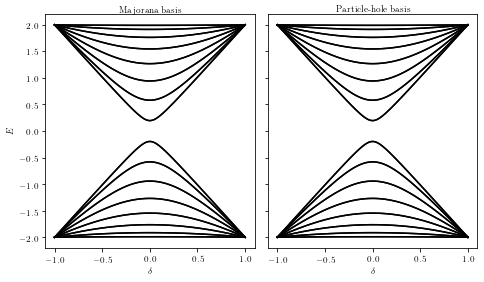

In [7]:
fig,ax=plt.subplots(1,2,sharey=True)
for index in range(eigvallist_f[0].shape[0]):
    ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
    ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
[ax.set_xlabel(r'$\delta$') for ax in ax]
ax[0].set_ylabel(r'$E$')
[ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-apbc.pdf',bbox_inches='tight')


In [8]:
delta_list=np.linspace(-1,1,100)
eigvallist_f=[]
eigvallist_m=[]
for delta in delta_list:
    params=Params(delta,L=16,bc=0)
    params.bandstructure('f')
    params.bandstructure('m')
    eigvallist_f.append(params.val_f)
    eigvallist_m.append(params.val_m)


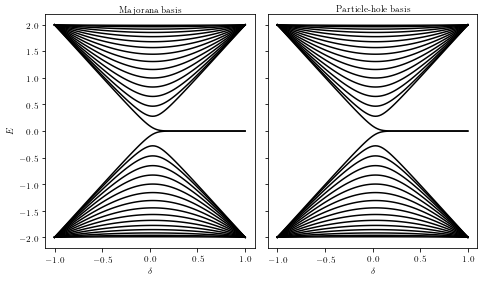

In [9]:
fig,ax=plt.subplots(1,2,sharey=True)
for index in range(eigvallist_m[0].shape[0]):
    ax[0].plot(delta_list,np.array(eigvallist_m)[:,index],'k')
    ax[1].plot(delta_list,np.array(eigvallist_f)[:,index],'k')
[ax.set_xlabel(r'$\delta$') for ax in ax]
ax[0].set_ylabel(r'$E$')
[ax.text(.5,1,text,transform=ax.transAxes,ha='center',va='bottom') for ax,text in zip(ax,('Majorana basis','Particle-hole basis'))]

fig.tight_layout()

# fig.savefig('/mnt/d/kitp/Rp_SPT/3/bandstructure-obc.pdf',bbox_inches='tight')


# Covariance and Correlation matrix

In [10]:
params=Params(delta=-0.3,L=16,bc=-1)

In [11]:
params.covariance_matrix_m()
params.covariance_matrix_f()

In [12]:
l=8
val_sub={}
val_sub['f']=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
val_sub['m']=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

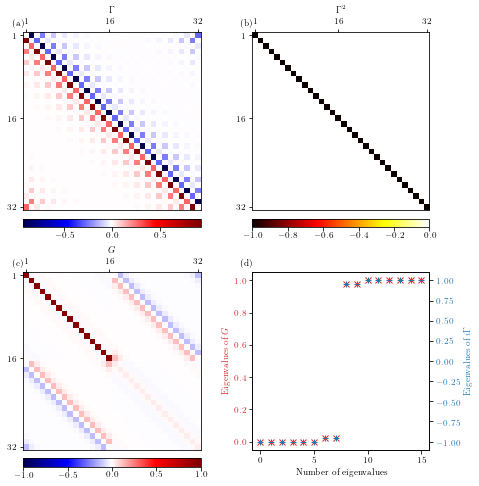

In [13]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,15,31]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,16,32]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,16,32]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/3/cov.pdf',bbox_inches='tight')


In [596]:
params=Params(delta=0,L=128,bc=-1)
# params=Params(delta=1,L=64,bc=-1)
params.covariance_matrix_m()
params.covariance_matrix_f()
l=40
val_sub={}
val_sub['f']=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
val_sub['m']=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

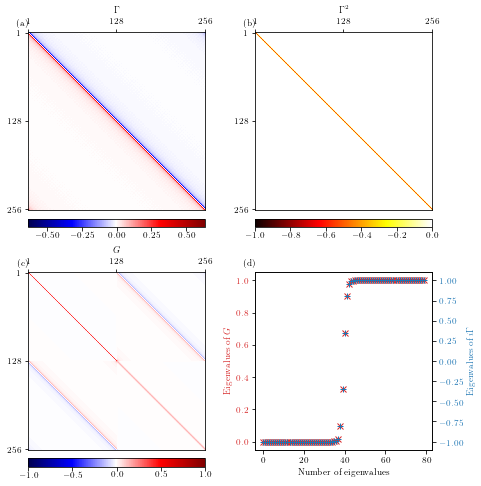

In [597]:
fig,ax=plt.subplots(2,2,figsize=(6.8,6.8))
im0=ax[0,0].imshow(params.C_m,cmap='seismic')
im1=ax[0,1].imshow(params.C_m@params.C_m,cmap='hot')
ax[0,0].text(0.5,1.1,r'$\Gamma$',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(0.5,1.1,r'$\Gamma^2$',transform=ax[0,1].transAxes,ha='center',va='bottom')


# [ax.set_box_aspect(1) for ax in ax]

axins0=ax[0,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,0].transAxes) 
cb0=fig.colorbar(im0,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)

axins1=ax[0,1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0,1].transAxes) 
cb1=fig.colorbar(im1,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)

im2=ax[1,0].imshow(params.C_f,cmap='seismic',vmax=1,vmin=-1)
ax[1,0].text(0.5,1.1,r'$G$',transform=ax[1,0].transAxes,ha='center',va='bottom')
axins2=ax[1,0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1,0].transAxes) 
cb2=fig.colorbar(im2,cax=axins2,orientation='horizontal')
cb2.ax.xaxis.set_tick_params(pad=0)

color = 'tab:red'
ax[1,1].plot(val_sub['f'],'.',marker="x",color=color)
ax[1,1].set_xlabel('Number of eigenvalues')
ax[1,1].set_ylabel(r'Eigenvalues of $G$', color=color)
ax[1,1].tick_params(axis='y', labelcolor=color)


ax2=ax[1,1].twinx()
color = 'tab:blue'
ax2.plot(val_sub['m'],'.',marker="+",color=color)
ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

[ax.xaxis.set_label_position('top') for ax in ax.flatten()[:3]]
[ax.xaxis.tick_top() for ax in ax.flatten()[:3]]
[ax.set_xticks([0,params.L-1,2*params.L-1]) for ax in ax.flatten()[:3]]
[ax.set_yticks([0,params.L-1,2*params.L-1]) for ax in ax.flatten()[:3]]
[ax.set_xticklabels([1,params.L,2*params.L]) for ax in ax.flatten()[:3]]
[ax.set_yticklabels([1,params.L,2*params.L]) for ax in ax.flatten()[:3]]

[ax.text(-0.,1.02,'({})'.format(text),transform=ax.transAxes,ha='right',va='bottom') for ax,text in zip(ax.flatten(),'abcd')]
ax[1,1].set_box_aspect(1)
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/4/cov.pdf',bbox_inches='tight')


In [622]:
# val_sub_f={}
# val_sub_m={}
for i in (0.02,):
    params=Params(delta=i,L=128,bc=-1)
    params.covariance_matrix_m()
    params.covariance_matrix_f()
    l=40
    val_sub_f[i]=la.eigh(params.c_subregion_f(np.arange(l)),eigvals_only=True)
    val_sub_m[i]=la.eigh(1j*params.c_subregion_m(np.arange(2*l)),eigvals_only=True)

In [624]:
val_sub_f.keys()

dict_keys([-0.01, 0, 0.01, -0.1, 0.1, 0.05, -0.05, -0.02, 0.02])

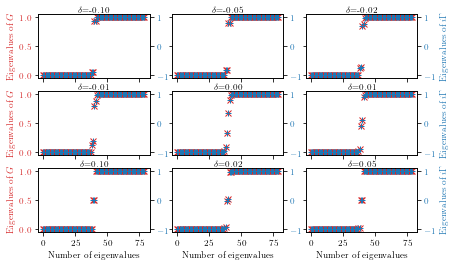

In [818]:
fig,axs=plt.subplots(3,3,sharex=True,sharey=True)

delta_list=(-0.1,-0.05,-0.02,-0.01,0,0.01,0.1,0.02,0.05,0.1)

for index,(ax,delta) in enumerate(zip(axs.flatten(),delta_list)):
    color = 'tab:red'
    ax.plot(val_sub_f[delta],'.',marker="x",color=color)
    if index>=6:
        ax.set_xlabel('Number of eigenvalues')
    ax.tick_params(axis='y', labelcolor=color)
    if index % 3==0:
        [ax.set_ylabel(r'Eigenvalues of $G$', color=color) for ax in axs[:,0]]

    ax.text(.5,1,r'$\delta$={:.2f}'.format(delta),ha='center',va='bottom',transform=ax.transAxes)

    ax2=ax.twinx()
    color = 'tab:blue'
    ax2.plot(val_sub_m[delta],'.',marker="+",color=color)
    if (index-2) %3 ==0:
        ax2.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

fig.savefig('/mnt/d/kitp/Rp_SPT/5/entanglement_spectrum.pdf',bbox_inches='tight')

# [ax.set_ylabel(r'Eigenvalues of $i\Gamma$', color=color)]

# Mutual information

In [16]:
delta_list=np.linspace(-1,1,100)**5
mutual_info_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    mutual_info_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))

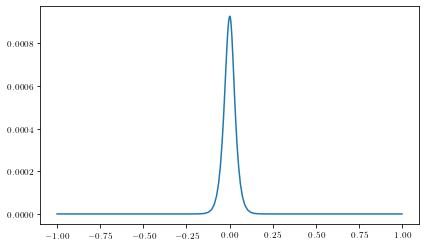

In [17]:
plt.plot(delta_list,mutual_info_list/np.log(2))

# Profiling

In [559]:
p_n.Hamiltonian_m-p_o.Hamiltonian_m

matrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

In [560]:
st=time.time()
%lprun -f Params.__init__ p_n=Params(delta=0,L=64,bc=-1,basis='mf')
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print((time.time()-st))

0.0064029693603515625


Timer unit: 1e-06 s

Total time: 0.003234 s
File: <ipython-input-557-17d109a854ab>
Function: __init__ at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                               def __init__(self,
    12                                               delta=0,    
    13                                               L=100,
    14                                               T=0,
    15                                               bc=1,    # 0: open boundary condition; >0: PBC; <0: APBC
    16                                               basis='mf'    # 'generate Hamiltonian of fermionic ('f') and Majorana basis ('m') or both ('mf')
    17                                               ):
    18         1          3.0      3.0      0.1          self.delta=delta
    19         1          1.0      1.0      0.0          self.mu=2*(1-delta)
    20         1          1.0      1.0      0.0          self.t=-(1+delta)
    21         1         

In [526]:
st=time.time()
%lprun -f Params.__init__ p_o=Params(delta=0,L=64,bc=-1)
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print(time.time()-st)

0.021459102630615234


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Timer unit: 1e-06 s

Total time: 0.017869 s
File: <ipython-input-525-de6be1346c5d>
Function: __init__ at line 42

Line #      Hits         Time  Per Hit   % Time  Line Contents
    42                                               def __init__(self,
    43                                               delta=0,    
    44                                               L=100,
    45                                               T=0,
    46                                               bc=1    # 0: open boundary condition; >0: PBC; <0: APBC
    47                                               ):
    48         1          2.0      2.0      0.0          self.delta=delta
    49         1          2.0      2.0      0.0          self.mu=2*(1-delta)
    50         1          1.0      1.0      0.0          self.t=-(1+delta)
    51         1          1.0      1.0      0.0          self.Delta=-(1+delta)
    52         1          0.0      0.0      0.0          self.L=L
    53         1       1279.0  

In [503]:
st=time.time()
%lprun -f Params.__init__ Params(delta=0,L=64,bc=-1)
# params.measure_all_random_even(16,(int(params.L/2),params.L))
print(time.time()-st)

0.02645087242126465


/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Timer unit: 1e-06 s

Total time: 0.022722 s
File: <ipython-input-397-4e89c48193fa>
Function: __init__ at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                               def __init__(self,
    12                                               delta=0,    
    13                                               L=100,
    14                                               T=0,
    15                                               bc=1    # 0: open boundary condition; >0: PBC; <0: APBC
    16                                               ):
    17         1          3.0      3.0      0.0          self.delta=delta
    18         1         16.0     16.0      0.1          self.mu=2*(1-delta)
    19         1          1.0      1.0      0.0          self.t=-(1+delta)
    20         1          1.0      1.0      0.0          self.Delta=-(1+delta)
    21         1          1.0      1.0      0.0          self.L=L
    22         1       2447.0  

In [476]:
np.sort(params.i_history)

array([32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62])

In [477]:
params.s_history

[0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]

In [401]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.measure_all_random_even params.measure_all_random_even(12,(int(params.L/2),params.L))

Timer unit: 1e-06 s

Total time: 0.015792 s
File: <ipython-input-397-4e89c48193fa>
Function: measure_all_random_even at line 325

Line #      Hits         Time  Per Hit   % Time  Line Contents
   325                                               def measure_all_random_even(self,batchsize,proj_range):
   326                                                   '''
   327                                                   proj_range: (start,end) tuple
   328                                                   '''
   329         1          2.0      2.0      0.0          self.i_history=[]
   330         1          1.0      1.0      0.0          self.s_history=[]        
   331         1          2.0      2.0      0.0          proj_range_even=[i//2 for i in proj_range]
   332         1         70.0     70.0      0.4          choice=np.random.choice(range(*proj_range_even),batchsize,replace=False)
   333        13         38.0      2.9      0.2          for i in choice:
   334        12        197

In [115]:
%%prun
delta_dict={}
mutual_info_dis_dict={}
for i in (12,):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

12


In [610]:
m = range(25)
m =np.reshape(m,(5,5))
print(m)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


In [616]:
m[[1,-2],:]

array([[ 5,  8,  7,  6,  9],
       [15, 18, 17, 16, 19]])

In [614]:
m[:,[1,-2]]=m[:,[-2,1]]

In [615]:
print(m)

[[ 0  3  2  1  4]
 [ 5  8  7  6  9]
 [10 13 12 11 14]
 [15 18 17 16 19]
 [20 23 22 21 24]]


In [201]:
idx=1
m[idx:,:]=np.roll(m[idx:,:],-1,0)
m[:,idx:]=np.roll(m[:,idx:],-1,1)
print(m)

[[ 0  2  3  4  1]
 [10 12 13 14 11]
 [15 17 18 19 16]
 [20 22 23 24 21]
 [ 5  7  8  9  6]]


In [202]:
jdx=2
m[jdx:,:]=np.roll(m[jdx:,:],-1,0)
m[:,jdx:]=np.roll(m[:,jdx:],-1,1)
print(m)

[[ 0  2  4  1  3]
 [10 12 14 11 13]
 [20 22 24 21 23]
 [ 5  7  9  6  8]
 [15 17 19 16 18]]


In [203]:
m[jdx:,:]=np.roll(m[jdx:,:],1,0)
m[:,jdx:]=np.roll(m[:,jdx:],1,1)
print(m)

[[ 0  2  3  4  1]
 [10 12 13 14 11]
 [15 17 18 19 16]
 [20 22 23 24 21]
 [ 5  7  8  9  6]]


In [204]:
m[idx:,:]=np.roll(m[idx:,:],1,0)
m[:,idx:]=np.roll(m[:,idx:],1,1)
print(m)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]


In [155]:
np.roll(m,1,axis=1)

array([[ 4,  0,  1,  2,  3],
       [ 9,  5,  6,  7,  8],
       [14, 10, 11, 12, 13],
       [19, 15, 16, 17, 18],
       [24, 20, 21, 22, 23]])

In [148]:
np.roll(m[row][:column+1], 1)

array([3, 1, 2])

In [630]:
params=Params(delta=0.3,L=64,bc=-1)
params.covariance_matrix_m()
z1=(params.C_m_history)
params.measure_obs(0,2,3)
params.measure_obs(0,12,13)
z11=params.C_m_history

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [629]:
params2=Params(delta=0.3,L=64,bc=-1)
params2.covariance_matrix_m()
z2=params2.C_m_history
params2.measure(0,2,3)
params2.measure(0,12,13)
z21=params2.C_m_history

In [628]:
params3=Params(delta=0.3,L=64,bc=-1)
params3.covariance_matrix_m()
z3=(params3.C_m_history)
params3.measure_new(0,2,3)
params3.measure_new(0,12,13)
z31=params3.C_m_history

In [ ]:
params.m

In [ ]:
params2.m

In [358]:
(params.m-params2.m).max()

1.0369075543018473

In [ ]:
z1[0]-z2[0]

In [637]:
z1[-3]-z2[-3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [640]:
z3[-1]-z2[-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
z11[0]-z1[0]

In [ ]:
z21[0]-z2[0]

In [ ]:
(z2[-1]-z1[-1]).max()

In [ ]:
params2.C_m_history[0]-params.C_m_history[0]


In [399]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

Timer unit: 1e-06 s

Total time: 2.3e-05 s
File: <ipython-input-397-4e89c48193fa>
Function: projection at line 97

Line #      Hits         Time  Per Hit   % Time  Line Contents
    97                                               def projection(self,s):
    98                                                   '''
    99                                                   s= 0,1 occupancy number
   100                                                   i,j: adjacent pair of Majorana
   101                                                   flow is from alpha_{i,j} to gamma_{i,j}
   102                                           
   103                                                   return: the basis are ordered as gamma_i,gamma_j,alpha_j,alpha_i
   104                                                   '''
   105         1          1.0      1.0      4.3          assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
   106                                                   # blkmat=(np.ar

In [394]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

Timer unit: 1e-06 s

Total time: 0.000199 s
File: <ipython-input-393-3a556dec652e>
Function: projection at line 97

Line #      Hits         Time  Per Hit   % Time  Line Contents
    97                                               def projection(self,s):
    98                                                   '''
    99                                                   s= 0,1 occupancy number
   100                                                   i,j: adjacent pair of Majorana
   101                                                   flow is from alpha_{i,j} to gamma_{i,j}
   102                                           
   103                                                   return: the basis are ordered as gamma_i,gamma_j,alpha_j,alpha_i
   104                                                   '''
   105         1          1.0      1.0      0.5          assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
   106         1         10.0     10.0      5.0          blkmat=(np.arr

In [382]:
params=Params(delta=delta,L=64,bc=-1)
%lprun -f params.projection params.projection(1)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Timer unit: 1e-06 s

Total time: 0.000966 s
File: <ipython-input-380-d10d7359a7fb>
Function: projection at line 85

Line #      Hits         Time  Per Hit   % Time  Line Contents
    85                                               def projection(self,s):
    86                                                   '''
    87                                                   s= 0,1 occupancy number
    88                                                   i,j: adjacent pair of Majorana
    89                                                   flow is from alpha_{i,j} to gamma_{i,j}
    90                                           
    91                                                   return: the basis are ordered as gamma_i,gamma_j,alpha_j,alpha_i
    92                                                   '''
    93         1          1.0      1.0      0.1          assert (s==0 or s==1),"s={} is either 0 or 1".format(s)
    94         1         10.0     10.0      1.0          blkmat=(np.arr

In [592]:
pp_o=Params(delta=0.3,L=64,bc=-1)
%lprun -f Params.bandstructure_obs pp_o.bandstructure_obs('m')

Timer unit: 1e-06 s

Total time: 0.008973 s
File: <ipython-input-577-7f5542689ab9>
Function: bandstructure_obs at line 79

Line #      Hits         Time  Per Hit   % Time  Line Contents
    79                                               def bandstructure_obs(self,H_type='f'):    
    80         1          2.0      2.0      0.0          if H_type=='f':    
    81                                                       val,vec=la.eigh(self.Hamiltonian_f)
    82                                                       sortindex=np.argsort(val)
    83                                                       self.val_f=val[sortindex]
    84                                                       self.vec_f=vec[:,sortindex]
    85         1          1.0      1.0      0.0          elif H_type=='m':
    86         1       8622.0   8622.0     96.1              val,vec=la.eigh(self.Hamiltonian_m) 
    87         1         59.0     59.0      0.7              sortindex=np.argsort(val)
    88         1    

In [593]:
pp_n=Params(delta=0.3,L=64,bc=-1)
%lprun -f Params.bandstructure pp_n.bandstructure('m')

Timer unit: 1e-06 s

Total time: 0.002012 s
File: <ipython-input-577-7f5542689ab9>
Function: bandstructure at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                               def bandstructure(self,basis='mf'):
    94         1          2.0      2.0      0.1          if 'f' in basis:    
    95                                                       val,vec=la.eigh(self.Hamiltonian_f)
    96                                                       sortindex=np.argsort(val)
    97                                                       self.val_f=val[sortindex]
    98                                                       self.vec_f=vec[:,sortindex]
    99         1          1.0      1.0      0.0          if 'm' in basis:
   100         1       1904.0   1904.0     94.6              val,vec=np.linalg.eigh(self.Hamiltonian_m) 
   101         1         31.0     31.0      1.5              sortindex=np.argsort(val)
   102         1         

In [602]:
params=Params(delta=delta,L=64,bc=-1)
# params.covariance_matrix_m()
%lprun -f params.covariance_matrix_m params.covariance_matrix_m()

Timer unit: 1e-06 s

Total time: 0.002333 s
File: <ipython-input-577-7f5542689ab9>
Function: covariance_matrix_m at line 121

Line #      Hits         Time  Per Hit   % Time  Line Contents
   121                                               def covariance_matrix_m(self,E_F=0):
   122         1          2.0      2.0      0.1          if not (hasattr(self,'val_m') and hasattr(self,'vec_m')):
   123         1       1595.0   1595.0     68.4              self.bandstructure('m')
   124         1         29.0     29.0      1.2          occupancy=self.fermi_dist(self.val_m,E_F)
   125         1         58.0     58.0      2.5          occupancy_mat=np.matlib.repmat(occupancy,self.vec_m.shape[0],1)
   126         1        574.0    574.0     24.6          self.C_m=(1j*2*(occupancy_mat*self.vec_m)@self.vec_m.T.conj())-1j*np.eye(self.L*2)
   127         1         67.0     67.0      2.9          assert np.abs(np.imag(self.C_m)).max()<1e-10, "Covariance matrix not real"
   128         1          6.0

In [644]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure_new params.measure_new(0,14,15)

Timer unit: 1e-06 s

Total time: 0.001268 s
File: <ipython-input-617-c65d2cd97b96>
Function: measure_new at line 246

Line #      Hits         Time  Per Hit   % Time  Line Contents
   246                                               def measure_new(self,s,i,j):
   247         1          4.0      4.0      0.3          if not hasattr(self,'C_m'):
   248                                                       self.covariance_matrix_m()
   249                                                   
   250                                                   # m=np.arange(64).reshape((8,8))
   251                                                   
   252         1         36.0     36.0      2.8          m=self.C_m_history[-1].copy()
   253                                                   # i<-> -2
   254         1         34.0     34.0      2.7          m[[i,-2]]=m[[-2,i]]
   255         1         18.0     18.0      1.4          m[:,[i,-2]]=m[:,[-2,i]]
   256                                        

In [642]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure params.measure(0,11,12)

Timer unit: 1e-06 s

Total time: 0.001188 s
File: <ipython-input-617-c65d2cd97b96>
Function: measure at line 201

Line #      Hits         Time  Per Hit   % Time  Line Contents
   201                                               def measure(self,s,i,j):
   202         1          3.0      3.0      0.3          if not hasattr(self,'C_m'):
   203                                                       self.covariance_matrix_m()
   204                                                   
   205                                                   # m=np.arange(64).reshape((8,8))
   206                                                   
   207         1         23.0     23.0      1.9          m=self.C_m_history[-1].copy()
   208         1        117.0    117.0      9.8          m[i:,:]=np.roll(m[i:,:],-1,0)
   209         1         74.0     74.0      6.2          m[:,i:]=np.roll(m[:,i:],-1,1)
   210                                           
   211         1          1.0      1.0      0.1        

In [648]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure params.measure(0,14,15)

Timer unit: 1e-06 s

Total time: 0.00088 s
File: <ipython-input-647-99c13608d4d5>
Function: measure at line 248

Line #      Hits         Time  Per Hit   % Time  Line Contents
   248                                               def measure(self,s,i,j):
   249         1          2.0      2.0      0.2          if not hasattr(self,'C_m'):
   250                                                       self.covariance_matrix_m()
   251                                                   
   252                                                   # m=np.arange(64).reshape((8,8))
   253                                                   
   254         1         22.0     22.0      2.5          m=self.C_m_history[-1].copy()
   255                                                   # i<-> -2
   256         1         21.0     21.0      2.4          m[[i,-2]]=m[[-2,i]]
   257         1         11.0     11.0      1.2          m[:,[i,-2]]=m[:,[-2,i]]
   258                                                 

In [646]:
params=Params(delta=delta,L=64,bc=-1)
params.covariance_matrix_m()
%lprun -f params.measure_obs params.measure_obs(0,14,15)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Timer unit: 1e-06 s

Total time: 0.008301 s
File: <ipython-input-617-c65d2cd97b96>
Function: measure_obs at line 156

Line #      Hits         Time  Per Hit   % Time  Line Contents
   156                                               def measure_obs(self,s,i,j):
   157         1       1159.0   1159.0     14.0          permutation_mat=sp.diags([1],[0],(self.L*2,self.L*2)).tocsr()
   158                                                   # i <-> -2
   159         1        246.0    246.0      3.0          permutation_mat[i,i]=0
   160         1        220.0    220.0      2.7          permutation_mat[-2,-2]=0
   161         1       1551.0   1551.0     18.7          permutation_mat[i,-2]=1
   162         1       1109.0   1109.0     13.4          permutation_mat[-2,i]=1
   163                                                   # j <-> -1
   164         1        242.0    242.0      2.9          permutation_mat[j,j]=0
   165         1        209.0    209.0      2.5          permutation_mat[-1,-1

In [598]:
%lprun -f mutual_info_run mutual_info_run(12)

Timer unit: 1e-06 s

Total time: 6.99575 s
File: <ipython-input-562-52e0aa0543ee>
Function: mutual_info_run at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mutual_info_run(batchsize):
     2         1        250.0    250.0      0.0      delta_list=np.linspace(-1,1,20)**3
     3         1          1.0      1.0      0.0      mutual_info_dis_list=[]
     4         1          1.0      1.0      0.0      if batchsize==0:
     5                                                   ensemblesize=1
     6                                               else:
     7         1          1.0      1.0      0.0          ensemblesize=15
     8                                           
     9        21         51.0      2.4      0.0      for delta in delta_list:
    10        20         21.0      1.1      0.0          mutual_info_ensemble_list=[]
    11       320       1005.0      3.1      0.0          for ensemble in range(ensem

In [403]:
%lprun -f mutual_info_run mutual_info_run(12)

Timer unit: 1e-06 s

Total time: 12.3388 s
File: <ipython-input-121-52e0aa0543ee>
Function: mutual_info_run at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mutual_info_run(batchsize):
     2         1        222.0    222.0      0.0      delta_list=np.linspace(-1,1,20)**3
     3         1          2.0      2.0      0.0      mutual_info_dis_list=[]
     4         1          2.0      2.0      0.0      if batchsize==0:
     5                                                   ensemblesize=1
     6                                               else:
     7         1          2.0      2.0      0.0          ensemblesize=15
     8                                           
     9        21         41.0      2.0      0.0      for delta in delta_list:
    10        20         17.0      0.8      0.0          mutual_info_ensemble_list=[]
    11       320        806.0      2.5      0.0          for ensemble in range(ensem

In [379]:
%lprun -f mutual_info_run mutual_info_run(12)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Timer unit: 1e-06 s

Total time: 31.1601 s
File: <ipython-input-121-52e0aa0543ee>
Function: mutual_info_run at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def mutual_info_run(batchsize):
     2         1        196.0    196.0      0.0      delta_list=np.linspace(-1,1,20)**3
     3         1          1.0      1.0      0.0      mutual_info_dis_list=[]
     4         1          0.0      0.0      0.0      if batchsize==0:
     5                                                   ensemblesize=1
     6                                               else:
     7         1          0.0      0.0      0.0          ensemblesize=15
     8                                           
     9        21         43.0      2.0      0.0      for delta in delta_list:
    10        20         15.0      0.8      0.0          mutual_info_ensemble_list=[]
    11       320        802.0      2.5      0.0          for ensemble in range(ensem

# Mutual info - density of operators

In [20]:
def mutual_info_run(batchsize):
    delta_list=np.linspace(-1,1,20)**3
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=100

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=64,bc=-1)
            params.measure_all_random_even(batchsize,(int(params.L/2),params.L))
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

In [22]:
np.random.rand()

0.9017744888141905

In [23]:
delta_dict={}
mutual_info_dis_dict={}
i=12
for i in (0,12,13,14,15,16):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)
print(time.time()-st)

0
12
13
14
15
16
1783.5289747714996


In [ ]:
for i in (0,13,14,15,16):
    print(i)
    delta_dict[i],mutual_info_dis_dict[i]=mutual_info_run(i)

In [25]:
delta_dict.keys()

dict_keys([0, 12, 13, 14, 15, 16])

Text(0, 0.5, 'Mutual information between A and B [$\\log2$]')

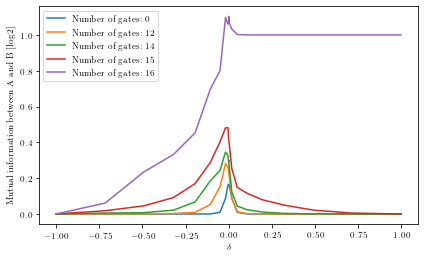

In [24]:
fig,ax=plt.subplots()
for i in (0,12,14,15,16):
    ax.plot(delta_dict[i],np.array(mutual_info_dis_dict[i]).mean(axis=1)/np.log(2),label='Number of gates: {}'.format(i))

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

# fig.savefig('/mnt/d/kitp/Rp_SPT/4/mutual_info_Ap_En200.pdf',bbox_inches='tight')


In [433]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

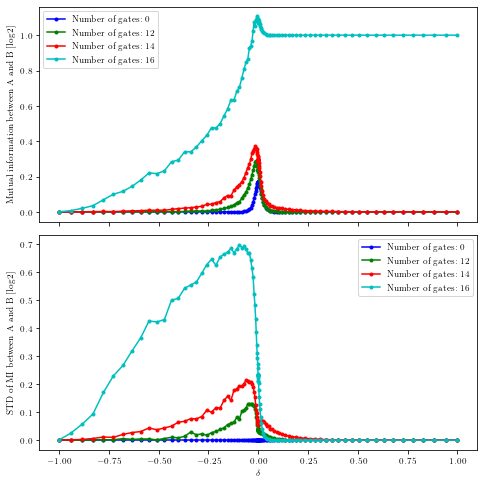

In [434]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [431]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

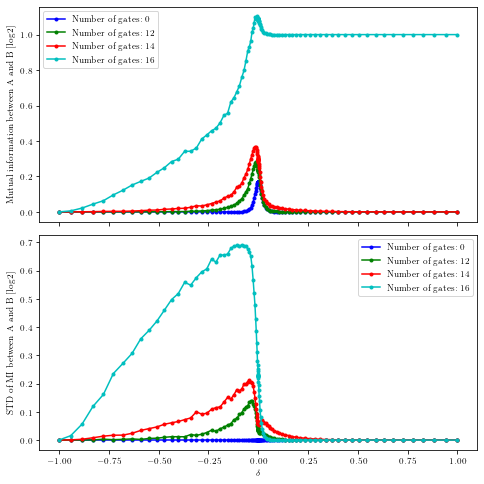

In [432]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [429]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

In [7]:
def remove_outlier(a):
    if np.array(a).shape[1]==1:
        return np.array(a)
    else:
        return np.sort(np.array(a),axis=1)[:,1:-1]

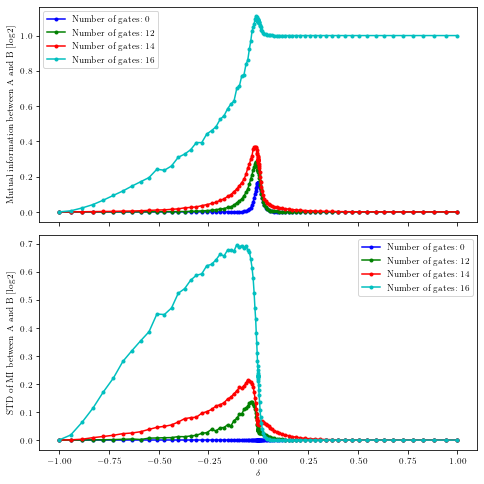

In [430]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [14]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

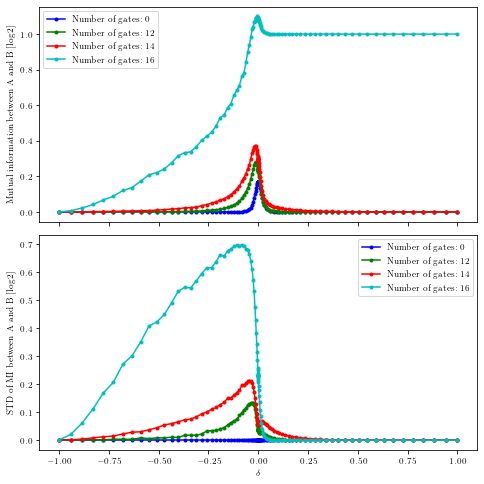

In [15]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


In [12]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_Ap_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

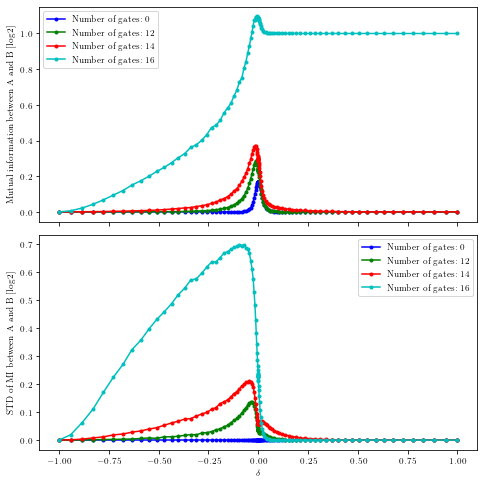

In [13]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],remove_outlier(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Number of gates: {}'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En{:d}.pdf'.format(es),bbox_inches='tight')


# Measure all gates to intermedate region with same projection

## Measurement on A or B after projection

In [824]:
# no measurment
delta_list=np.linspace(-1,1,100)**3
mutual_info_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    mutual_info_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

In [226]:
# all projections to 0
mutual_info_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    mutual_info_pos_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [227]:
# all projections to 0 followed by measuring 0 within A 
mutual_info_pos_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    mutual_info_pos_post0A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [825]:
# all projections to 0 followed by measuring 0 within A and B
mutual_info_pos_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,1)
    params.measure(0,64,65)
    mutual_info_pos_post0AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

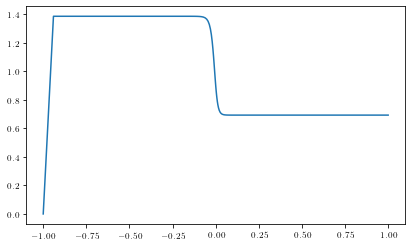

In [826]:
plt.plot(delta_list,mutual_info_pos_post0AB_list)

In [122]:
list(range(0,int(params.L/2),2))

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [123]:
# all projections to 0 followed by measuring 0 within all A
mutual_info_pos_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post0A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [127]:
# all projections to 0 followed by measuring 0 within all A & B
mutual_info_pos_post0AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(0,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post0AB_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [125]:
# all projections to 0 followed by measuring 1 within all A
mutual_info_pos_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post1A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [126]:
# all projections to 0 followed by measuring 1 within all A & B
mutual_info_pos_post1AB_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    [params.measure(1,i+params.L,i+1+params.L) for i in range(0,int(params.L/2),2)]
    mutual_info_pos_post1AB_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [19]:
# all projections to 0 followed by measuring 1 within A 
mutual_info_pos_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    mutual_info_pos_post1A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [18]:
# all projections to 0 followed by measuring 1 within A and B
mutual_info_pos_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,1)
    params.measure(1,64,65)
    mutual_info_pos_post1AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [90]:
# all projections to 0 followed by measuring 0 cross AB
mutual_info_pos_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(0,0,64)
    mutual_info_pos_post0A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [91]:
# all projections to 0 followed by measuring 1 cross AB
mutual_info_pos_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(1)
    params.measure(1,0,64)
    mutual_info_pos_post1A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

project to 0/1?
project within A, cross A and A', cross A and B, both within A and B sequentially


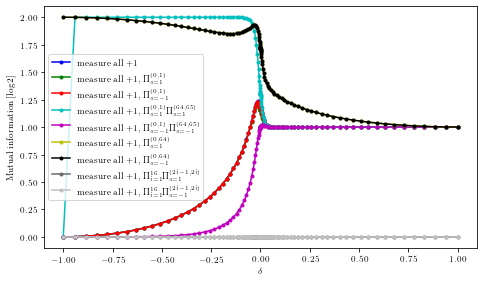

In [228]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),'.-',label='measure all +1',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=-1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0AB_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=1}^{(0,1)} \Pi_{s=1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1AB_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=-1}^{(0,1)} \Pi_{s=-1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_B_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=1}^{(0,64)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_B_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{s=-1}^{(0,64)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
ax.plot(delta_list,mutual_info_pos_post1A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_pos_post.pdf',bbox_inches='tight')

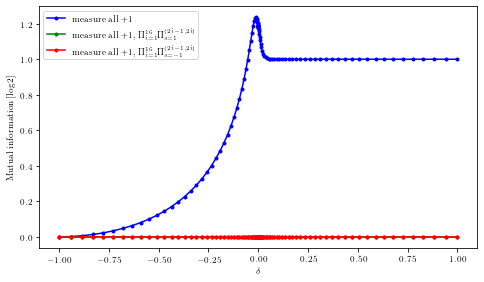

In [133]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),'.-',label='measure all +1',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post0A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_pos_post1A_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post0AB_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} \Pi_{i=32}^{48}\Pi_{s=1}^{(2i,2i+1)} $',color=colorlist.__next__())
# ax.plot(delta_list,mutual_info_pos_post1AB_all_list/np.log(2),'.-',label=r'measure all +1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} \Pi_{i=32}^{48}\Pi_{s=-1}^{(2i,2i+1)}$',color=colorlist.__next__())

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_pos_post_all.pdf',bbox_inches='tight')

In [82]:
# all projections to 1
mutual_info_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    mutual_info_neg_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [83]:
# all projections to 1, followed by measuring 0 within A
mutual_info_neg_post0A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    mutual_info_neg_post0A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [142]:
# all projections to 1 followed by measuring 0 within all A 
mutual_info_neg_post0A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(0,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_neg_post0A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [84]:
# all projections to 1, followed by measuring 1 within A
mutual_info_neg_post1A_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    mutual_info_neg_post1A_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [143]:
# all projections to 1 followed by measuring 1 within all A 
mutual_info_neg_post1A_all_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    [params.measure(1,i,i+1) for i in range(0,int(params.L/2),2)]
    mutual_info_neg_post1A_all_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [85]:
# all projections to 1, followed by measuring 0 within A and B
mutual_info_neg_post0AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,1)
    params.measure(0,64,65)
    mutual_info_neg_post0AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [86]:
# all projections to 1, followed by measuring 1 within A and B
mutual_info_neg_post1AB_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,1)
    params.measure(1,64,65)
    mutual_info_neg_post1AB_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [137]:
# all projections to 0 followed by measuring 0 cross AB
mutual_info_neg_post0A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(0,0,64)
    mutual_info_neg_post0A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [138]:
# all projections to 0 followed by measuring 1 cross AB
mutual_info_neg_post1A_B_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all(0)
    params.measure(1,0,64)
    mutual_info_neg_post1A_B_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

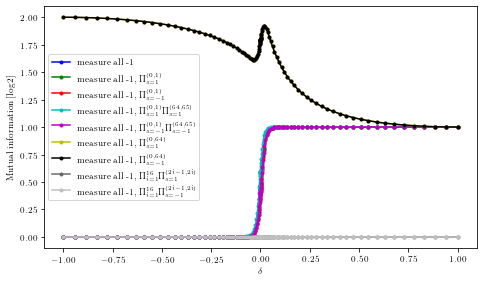

In [144]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),'.-',label='measure all -1',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,1)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0AB_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,1)} \Pi_{s=1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1AB_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,1)} \Pi_{s=-1}^{(64,65)}$',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_B_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=1}^{(0,64)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post1A_B_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{s=-1}^{(0,64)} $',color=colorlist.__next__())
ax.plot(delta_list,mutual_info_neg_post0A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=1}^{(2i-1,2i)} $',color='dimgray')
ax.plot(delta_list,mutual_info_neg_post1A_all_list/np.log(2),'.-',label=r'measure all -1, $\Pi_{i=1}^{16}\Pi_{s=-1}^{(2i-1,2i)} $',color='silver')


ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_neg_post.pdf',bbox_inches='tight')

## Random probabilty

In [156]:
with open('mutual_info_s_prob_En20.pickle','rb') as f:
    delta_s_prob_list,MI_s_prob_list=pickle.load(f)

Text(0, 0.5, 'Mutual information between A and B [$\\log2$]')

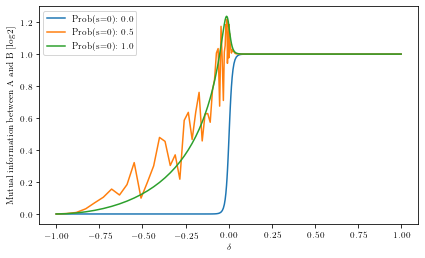

In [158]:
fig,ax=plt.subplots()
for i in delta_s_prob_list.keys():
    ax.plot(delta_s_prob_list[i],np.array(MI_s_prob_list[i]).mean(axis=1)/np.log(2),label='Prob(s=0): {}'.format(i))
    # ax.plot(delta_s_prob_list[i],np.array(MI_s_prob_list[i])/np.log(2),label='Number of gates: {}'.format(i))

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Ap_En200.pdf',bbox_inches='tight')


In [435]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

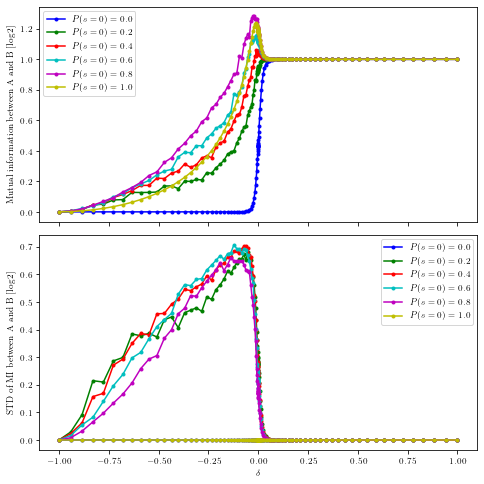

In [437]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [442]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

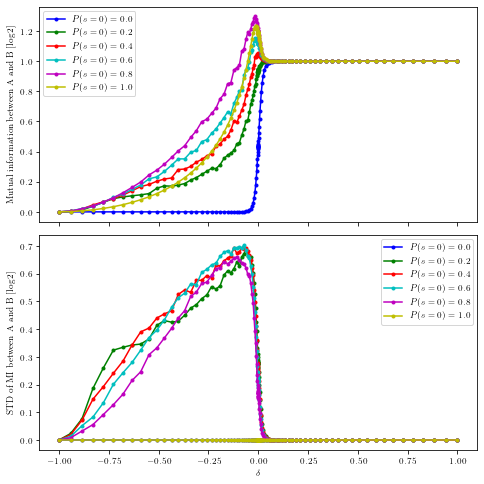

In [443]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [444]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

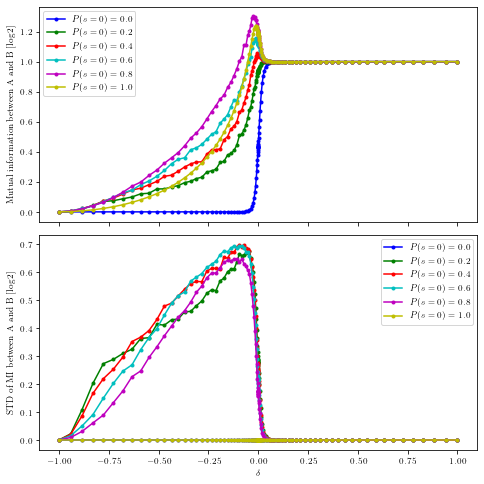

In [445]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [5]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

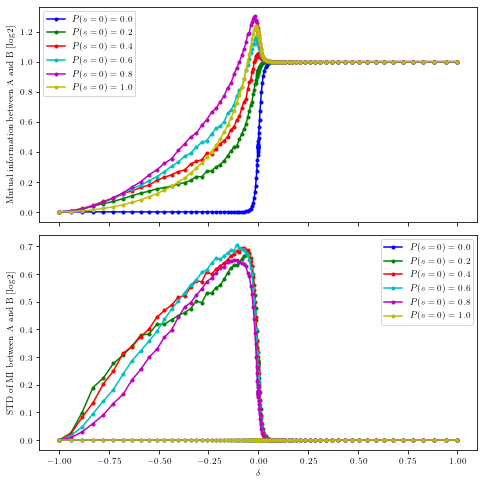

In [6]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [765]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

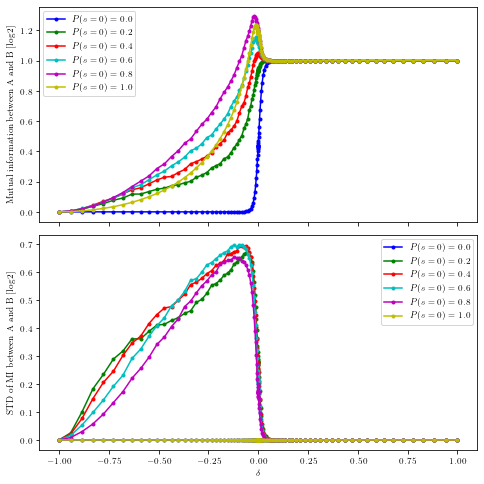

In [766]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


In [752]:
es=20000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_s_prob_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

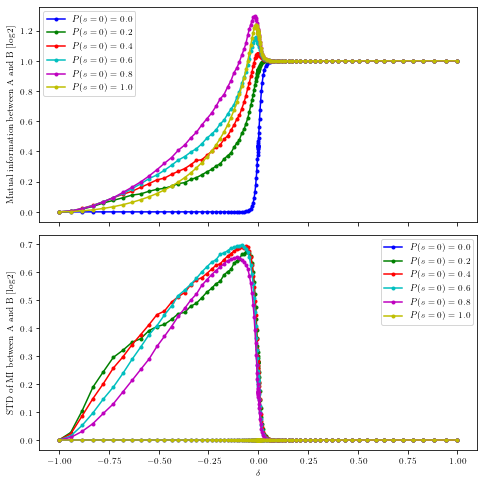

In [753]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.1f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_s_prob_En{:d}.pdf'.format(es),bbox_inches='tight')


## random position

In [516]:
# all projections to 0
mutual_info_pos_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(1.0)
    mutual_info_pos_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [511]:
# 0.5 projections to 0
mutual_info_x_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(8/(params.L/4))
    mutual_info_x_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [512]:
# all projections to 1
mutual_info_neg_list=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1)
    params.measure_all_position(0)
    mutual_info_neg_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [513]:
np.linspace(0,16,5)

array([ 0.,  4.,  8., 12., 16.])

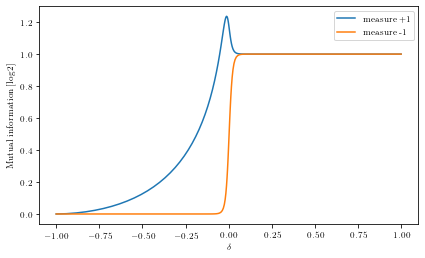

In [517]:
fig,ax=plt.subplots(figsize=(6.8,4))
# ax.plot(delta_list,mutual_info_list/np.log(2),label='no measurement')
ax.plot(delta_list,mutual_info_pos_list/np.log(2),label='measure +1')
# ax.plot(delta_list,mutual_info_x_list/np.log(2),label='0.5 measure -1')
ax.plot(delta_list,mutual_info_neg_list/np.log(2),label='measure -1')
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
ax.legend()
# fig.savefig('/mnt/d/kitp/Rp_SPT/4/M_L64_ApBp_shared.pdf',bbox_inches='tight')

In [16]:
es=1000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

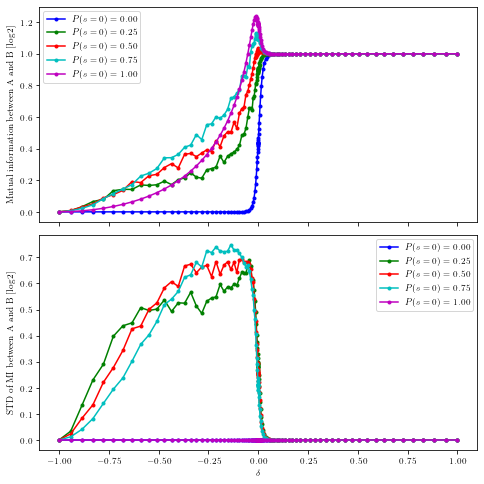

In [17]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [20]:
es=2000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

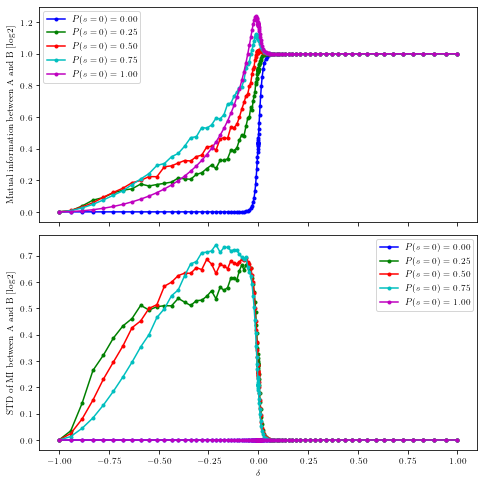

In [21]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [145]:
es=3000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

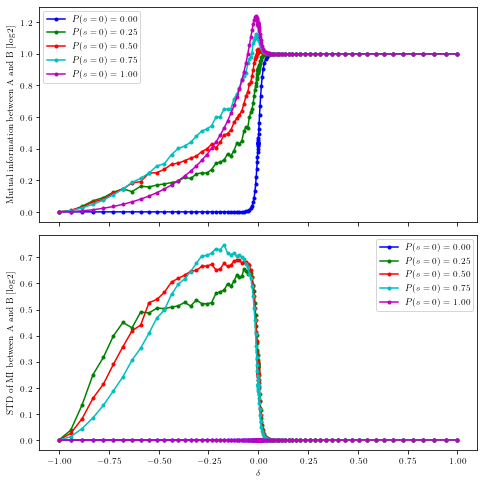

In [146]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [217]:
es=5000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

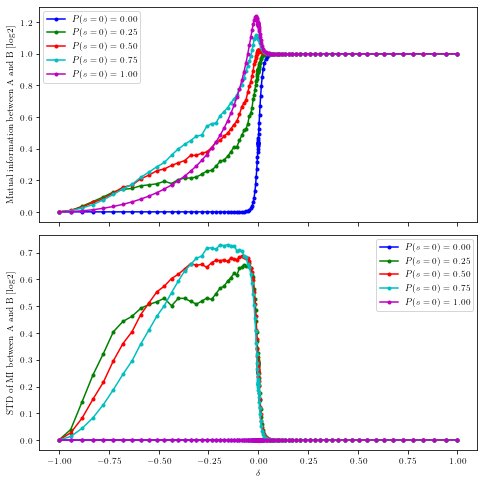

In [218]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [1186]:
es=10000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

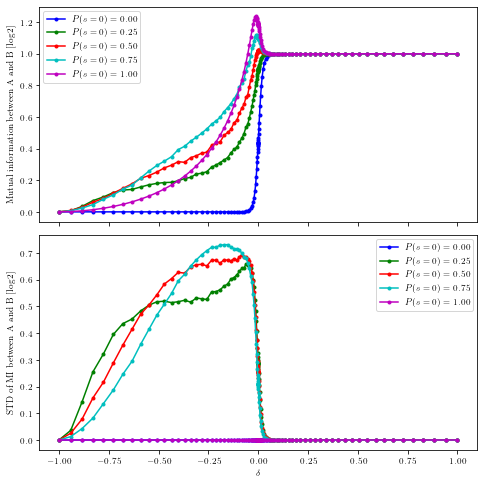

In [1187]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [637]:
es=20000
with open('/mnt/d/KITP/Rp_SPT/5/mutual_info_position_En{:d}.pickle'.format(es),'rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

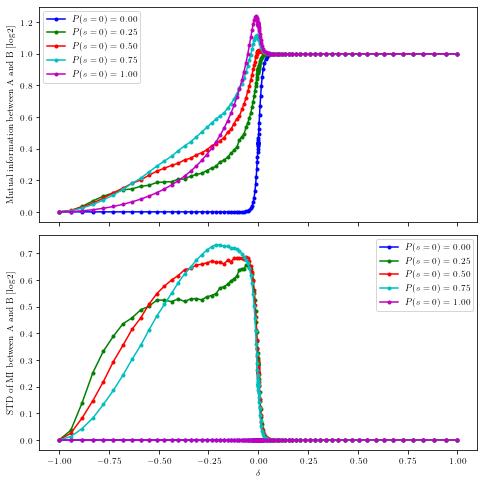

In [638]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


### All configs

In [919]:
deck = [10,20,30,40] #get deck of cards from 1 to 52
# comb = list(itertools.combinations(deck, 3)) # make list  with unic 2 cards combination
# len(comb) #output 1326

comb=itertools.combinations(deck, 3)

In [969]:
params=Params(L=64,bc=-1,basis='m')

In [970]:
s_list_list=params.generate_position_list(np.arange(int(params.L/2),params.L,2),.75)

In [971]:
params.measure_list(np.arange(int(params.L/2),params.L,2),s_list_list[0])

In [972]:
params.i_history

[32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62]

In [987]:
with open('mutual_info_position_exhaust_L32.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

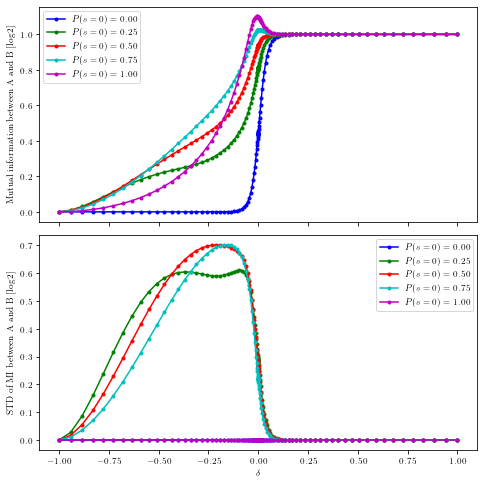

In [988]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_En{:d}.pdf'.format(es),bbox_inches='tight')


In [1183]:
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_exhaust_L64.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para=pickle.load(f)

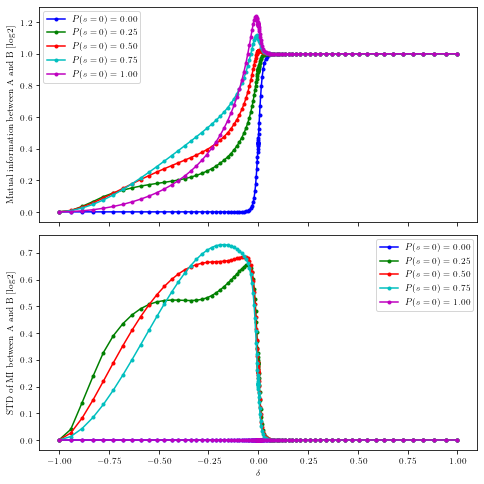

In [1185]:
fig,axs=plt.subplots(2,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label=r'$P(s=0)={:.2f}$'.format(i),color=color)

ax.legend()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_position_exhaust_L64.pdf',bbox_inches='tight')


In [937]:
def mutual_info_all_run(batchsize):
    delta_list=np.linspace(-1,1,40)
    mutual_info_dis_list=[]
    if batchsize==0:
        ensemblesize=1
    else:
        ensemblesize=100

    for delta in delta_list:
        mutual_info_ensemble_list=[]
        for ensemble in range(ensemblesize):
            params=Params(delta=delta,L=16,bc=-1)
            params.measure_batch(batchsize)    
            mutual_info_ensemble_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+30))
        mutual_info_dis_list.append(mutual_info_ensemble_list)
    return delta_list,mutual_info_dis_list

## Born rules

In [1150]:
params=Params(delta=-0.1,L=64,bc=-1,basis='m')

In [1143]:
params.covariance_matrix_m()

Object `params.covariance_matrix_m()` not found.


In [1151]:
params.measure_all_born()

0.09905770675475184
0.06289957905748506
0.055790613615858575
0.05373350464434967
0.05300454348000844
0.052712357658709075
0.05258515677918779
0.05252640251221824
0.05249802741001458
0.05248383904055082
0.05247654365576082
0.05247270549923966
0.052470647048657504
0.05246952485085654
0.05246890432583773
0.05246855688662522


In [1127]:
params.i_history

[32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62]

In [1128]:
params.s_history

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]

In [1068]:
print(np.round(params.C_m_history[-1][:6,:6],4))

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


In [1069]:
params.measure(0,2,3)
print(np.round(params.C_m_history[-1][:6,:6],4))

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


In [1074]:
len(params.C_m_history)

2

In [1070]:
print(params.C_m_history[-1][:4,:4])

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0. -1.  0.]]


In [1047]:
len(params.C_m_history)

1

In [1073]:
(1+params.C_m_history[-1][0,1])/2

0.5

In [1072]:
(1-params.C_m_history[-1][2,3])/2

0.0

In [1178]:
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En1000.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

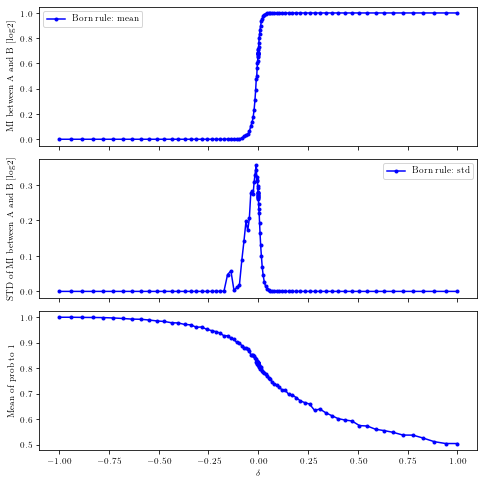

In [1181]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()
ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [1188]:
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En10000.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

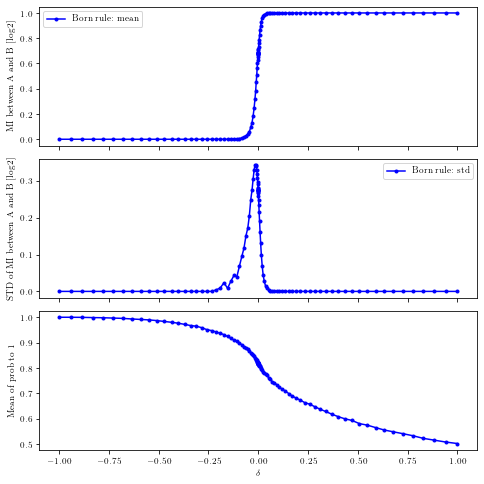

In [1189]:
fig,axs=plt.subplots(3,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()
ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [1201]:
es=50000
with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En50000.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

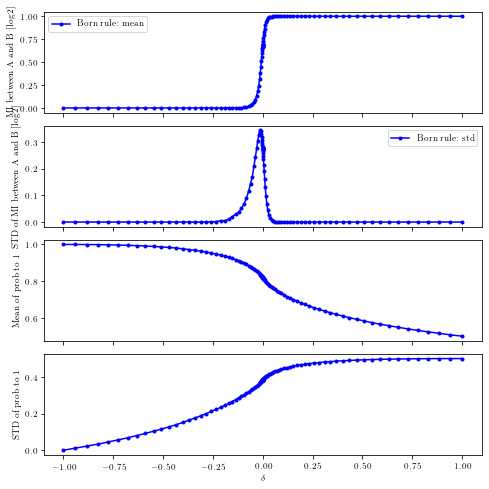

In [1202]:
fig,axs=plt.subplots(4,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'STD of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


In [1199]:
es=100000
# with open('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pickle'.format(es),'rb') as f:
#     delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

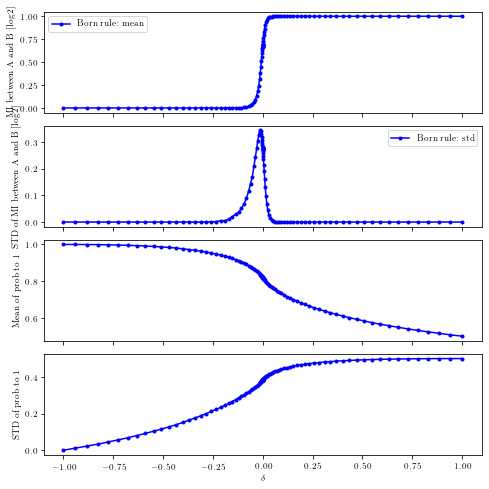

In [1200]:
fig,axs=plt.subplots(4,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).mean(axis=1)/np.log(2),'.-',label='Born rule: mean'.format(i),color=color)

ax.legend()
# ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'MI between A and B [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.array(mutual_info_dis_dict_para[i]).std(axis=1)/np.log(2),'.-',label='Born rule: std'.format(i),color=color)
ax.set_ylabel(r'STD of MI between A and B [$\log2$]')

ax.legend()

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'Mean of prob to 1')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2)),'.-',color=color)

ax.set_ylabel(r'STD of prob to 1')

ax.set_xlabel(r'$\delta$')
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/mutual_info_Born_En{:d}.pdf'.format(es),bbox_inches='tight')


# Scaling behavior: Peak height and position

## Distance

In [159]:
def decay_length():
    MI_list={}
    L_list={}
    for logL in np.linspace(2,6,20):
        L=np.exp(logL)
        params=Params(delta=0,L=L,bc=-1,basis='m')
        L_list.append(L)
        MI_list.append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))
    return L_list,MI_list


In [395]:
# no measurement
mutual_info_list={}
delta_list=np.linspace(-1,1,300)**5
for ApB in np.arange(34,65,2):
    mutual_info_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(32)
        subregionAp=np.arange(32,ApB,2)
        subregionB=np.arange(ApB,ApB+32)
        subregionBp=np.arange(ApB+32,2*params.L,2)
        # params.measure_all(1,subregionAp)
        # params.measure_all(1,subregionBp)
        mutual_info_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [396]:
mutual_info_pos_list={}

In [397]:
# all projections to 0
delta_list=np.linspace(-1,1,300)**5
for ApB in np.arange(34,65,2):
    mutual_info_pos_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(32)
        subregionAp=np.arange(32,ApB,2)
        subregionB=np.arange(ApB,ApB+32)
        subregionBp=np.arange(ApB+32,2*params.L,2)
        params.measure_all(1,subregionAp)
        # params.measure_all(1,subregionBp)
        mutual_info_pos_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [398]:
mutual_info_neg_list={}

In [399]:
# all projections to 1
delta_list=np.linspace(-1,1,300)**5
for ApB in np.arange(34,65,2):
    mutual_info_neg_list[ApB]=[]

    for delta in delta_list:
        params=Params(delta=delta,L=64,bc=-1)
        subregionA=np.arange(32)
        subregionAp=np.arange(32,ApB,2)
        subregionB=np.arange(ApB,ApB+32)
        subregionBp=np.arange(ApB+32,2*params.L,2)
        params.measure_all(0,subregionAp)
        mutual_info_neg_list[ApB].append(params.mutual_information_m(subregionA,subregionB))

In [363]:
ApB=64
subregionA=np.arange(32)
subregionAp=np.arange(32,ApB,2)
subregionB=np.arange(ApB,ApB+32)
subregionBp=np.arange(ApB+32,2*params.L,2)

In [364]:
subregionAp.shape[0]*2

32

In [323]:
np.arange(34,64,4)+2

array([36, 40, 44, 48, 52, 56, 60, 64])

In [329]:
mutual_info_pos_list.keys()

dict_keys([34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64])

In [ ]:
colorlist=('bgrcmyk')

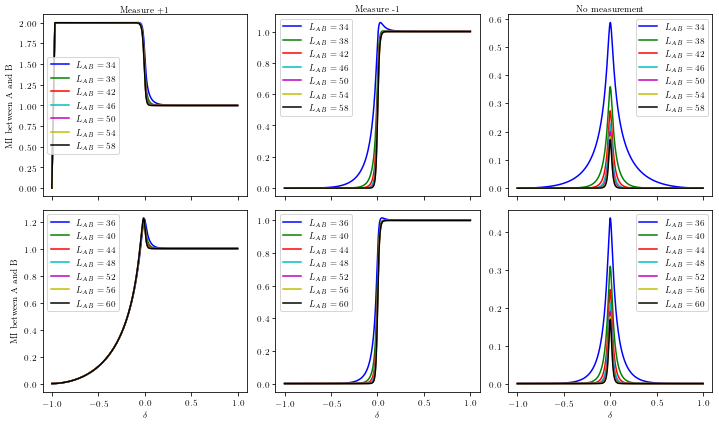

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(10,6),sharex=True)
colorlist=('bgrcmyk')
plotstyle='-'
for i,color in zip(np.arange(34,64,4),colorlist):
    ax[0,0].plot(delta_list,mutual_info_pos_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)
    ax[0,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)
    ax[0,2].plot(delta_list,mutual_info_list[i]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i),color=color)

    ax[1,0].plot(delta_list,mutual_info_pos_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)
    ax[1,1].plot(delta_list,mutual_info_neg_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)
    ax[1,2].plot(delta_list,mutual_info_list[i+2]/np.log(2),plotstyle,label=r'$L_{{AB}}={}$'.format(i+2),color=color)


[ax.legend() for ax in ax.flatten()]
[ax.set_xlabel('$\delta$') for ax in ax[1,:]]
ax[0,0].set_ylabel('MI between A and B [log 2]')
ax[1,0].set_ylabel('MI between A and B [log 2]')

ax[0,0].text(.5,1,'Measure +1',transform=ax[0,0].transAxes,ha='center',va='bottom')
ax[0,1].text(.5,1,'Measure -1',transform=ax[0,1].transAxes,ha='center',va='bottom')
ax[0,2].text(.5,1,'No measurement',transform=ax[0,2].transAxes,ha='center',va='bottom')

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_distance.pdf',bbox_inches='tight')

In [384]:
distance_list=[]
peak_list=[]
peak_pos_list=[]
for i in np.arange(34,64,4):
# plt.plot(delta_list,mutual_info_pos_list[i+2]/np.log(2))
    peak=(mutual_info_pos_list[i+2]/np.log(2)).max()
    peak_pos=delta_list[(np.argmax(mutual_info_pos_list[i+2]/np.log(2)))]
    # print('peak: {}, peak position: {}'.format(peak,peak_pos))
    distance_list.append(i+2)
    peak_list.append(peak)
    peak_pos_list.append(peak_pos)

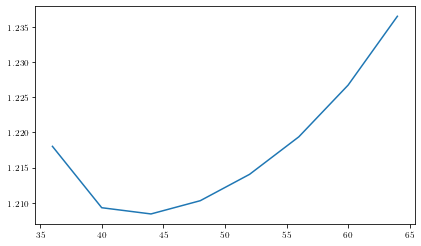

In [385]:
plt.plot(distance_list,peak_list)

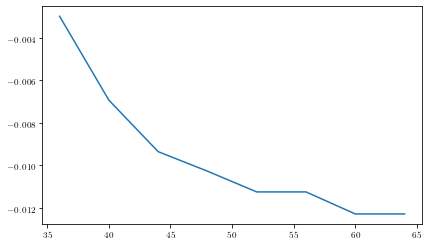

In [386]:
plt.plot(distance_list,peak_pos_list)

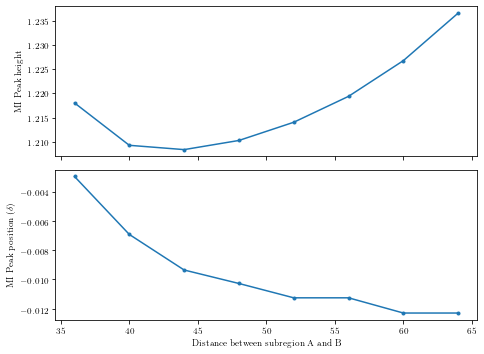

In [ ]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(6.8,5))
ax[0].plot(distance_list,peak_list,'.-')
ax[1].plot(distance_list,peak_pos_list,'.-')
ax[0].set_ylabel(r'MI Peak height ($\log 2$)')
ax[1].set_ylabel(r'MI Peak position ($\delta$)')
ax[1].set_xlabel('Distance between subregion A and B')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_distance_peakpos.pdf',bbox_inches='tight')

## System size 

In [831]:
# no measurment
mutual_info_list={}
delta_list=np.linspace(-1,1,100)**3
L_list=np.arange(16,101,4)
for L in L_list:
    mutual_info_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        mutual_info_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

In [832]:
# all projections to 0
mutual_info_pos_list={}
for L in L_list:
    mutual_info_pos_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1)
        mutual_info_pos_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [833]:
# all projections to 1
mutual_info_neg_list={}
for L in L_list:
    mutual_info_neg_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0)
        mutual_info_neg_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
L_list

array([ 16,  18,  20,  22,  24,  26,  28,  30,  32,  34,  36,  38,  40,
        42,  44,  46,  48,  50,  52,  54,  56,  58,  60,  62,  64,  66,
        68,  70,  72,  74,  76,  78,  80,  82,  84,  86,  88,  90,  92,
        94,  96,  98, 100])

In [ ]:
mutual_info_neg_list.keys()

dict_keys([0, 0.1, 0.2, 0.3, 0.4, 0.05, 0.02, 0.01, (0, 99), (1, 99), (2, 99), (3, 99), (4, 99), (5, 99), (6, 99), (7, 99), (8, 99), (9, 99)])

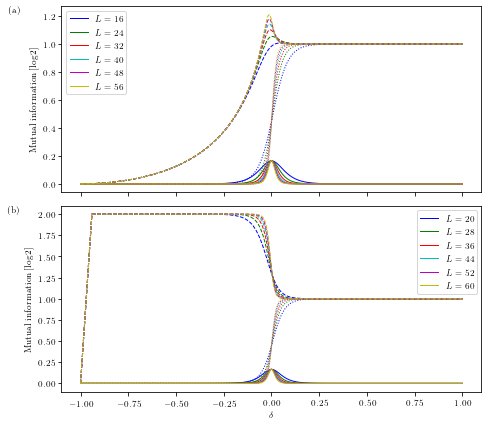

In [847]:
fig,ax=plt.subplots(2,1,figsize=(6.8,6),sharex=True)
# i=20
colorlist=('bgrcmyk')
for i,color in zip(range(16,64,8),colorlist):
    ax[0].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    ax[0].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    ax[0].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # i+=2
    # ax[0,1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    # ax[0,1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    # ax[0,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    i+=4
    ax[1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    ax[1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    ax[1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # i+=2
    # ax[1,1].plot(delta_list,mutual_info_list[i]/np.log(2),label=r'$L={}$'.format(i),ls='-',lw=1,color=color)
    # ax[1,1].plot(delta_list,mutual_info_pos_list[i]/np.log(2),ls='--',lw=1,color=color)
    # ax[1,1].plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)

    # ax[0,1].plot(delta_list,mutual_info_list[i+2]/np.log(2))

[ax.legend() for ax in ax.flatten()]
ax[1].set_xlabel(r'$\delta$')
[ax.set_ylabel(r'Mutual information [$\log 2$]') for ax in ax[:]]
[ax.text(-0.1,1,'({})'.format(text),ha='right',va='top',transform=ax.transAxes) for ax,text in zip(ax.flatten(),'abcd')]
fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size.pdf')

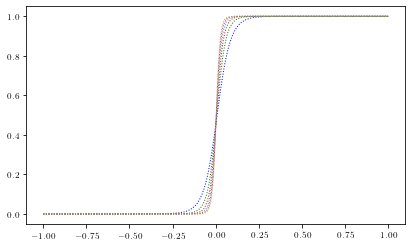

In [850]:
fig,ax=plt.subplots()
for i,color in zip(range(16,64,8),colorlist):
    ax.plot(delta_list,mutual_info_neg_list[i]/np.log(2),ls=':',lw=1,color=color)


In [857]:
f1=interpolate.interp1d(delta_list,mutual_info_neg_list[16]/np.log(2))
f2=interpolate.interp1d(delta_list,mutual_info_neg_list[16+8]/np.log(2))

In [887]:
def find_intersection(delta_list,d1,d2):
    f1=interpolate.interp1d(delta_list,d1)
    f2=interpolate.interp1d(delta_list,d2)
    x=np.arange(-0.01,0.01,1e-5)
    y=f1(x)-f2(x)
    x0=x[np.argmin(np.abs(y))]
    return x0,f1(x0).item()

In [893]:
delta0_list=[]
f0_list=[]
for i in range(16,56,8):
    x0,y0=find_intersection(delta_list,mutual_info_neg_list[i]/np.log(2),mutual_info_neg_list[i+8]/np.log(2))
    delta0_list.append(x0)
    f0_list.append(y0)

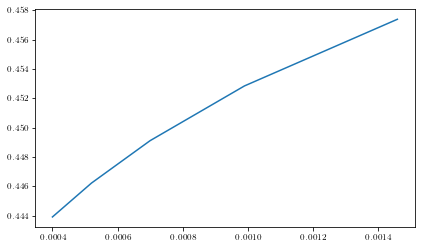

In [897]:
plt.plot(delta0_list,f0_list)

In [ ]:
# all projections to 0
mutual_info_pos_fine_list={}
delta_list=np.linspace(-.02,.06,100)
L_list=np.arange(16,401,8)
for L in L_list:
    mutual_info_pos_fine_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(1)
        mutual_info_pos_fine_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [899]:
# all projections to 1
mutual_info_neg_fine_list={}
delta_list=np.linspace(-.02,.06,100)
L_list=np.arange(16,401,8)
for L in L_list:
    mutual_info_neg_fine_list[L]=[]
    for delta in delta_list:
        params=Params(delta=delta,L=L,bc=-1)
        params.measure_all(0)
        mutual_info_neg_fine_list[L].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [527]:
L_list=[]
peak_list=[]
peak_pos_list=[]
for i in range(16,401,8):
# plt.plot(delta_list,mutual_info_pos_list[i+2]/np.log(2))
    peak=(mutual_info_pos_fine_list[i]/np.log(2)).max()
    peak_pos=delta_list[(np.argmax(mutual_info_pos_fine_list[i]/np.log(2)))]
    # print('peak: {}, peak position: {}'.format(peak,peak_pos))
    L_list.append(i)
    peak_list.append(peak)
    peak_pos_list.append(peak_pos)

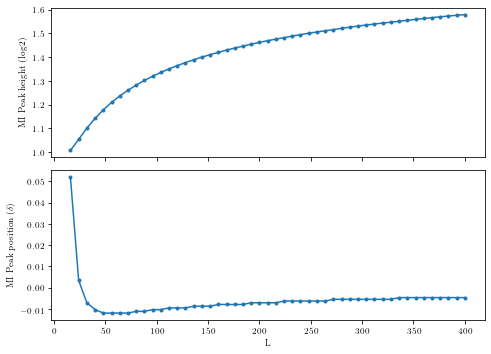

In [539]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(6.8,5))
ax[0].plot(L_list,peak_list,'.-')
ax[1].plot(L_list,peak_pos_list,'.-')
ax[0].set_ylabel(r'MI Peak height ($\log 2$)')
ax[1].set_ylabel(r'MI Peak position ($\delta$)')
ax[1].set_xlabel('L')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size_peakpos.pdf',bbox_inches='tight')

In [558]:
len(peak_list)

49

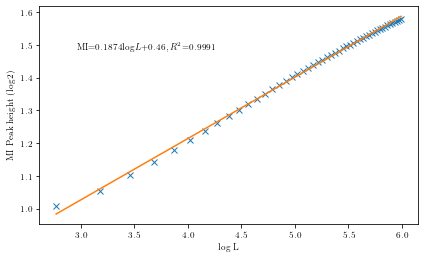

In [563]:
fig,ax=plt.subplots()
ax.plot(np.log(L_list),(peak_list),'.',marker='x')
ax.set_xlabel('log L')
ax.set_ylabel(r'MI Peak height ($\log 2$)')
lr=scipy.stats.linregress(np.log(L_list),(peak_list))
ax.plot(np.log(L_list),lr.slope*np.log(L_list)+lr.intercept)
ax.text(.1,.8,r'MI={:.4f}$\log L$+{:.2f},  $R^2$={:.4f}'.format(lr.slope,lr.intercept,lr.rvalue),transform=ax.transAxes)
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_scaling_size_peak_log.pdf',bbox_inches='tight')

In [543]:
lr

LinregressResult(slope=0.18743496018918687, intercept=0.4638923084636446, rvalue=0.999111393558343, pvalue=2.680977430247253e-66, stderr=0.0011533496377092156)

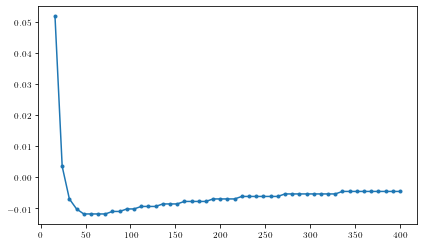

In [529]:
plt.plot(L_list,peak_pos_list,'.-')

In [212]:
MI_list=[]
L_list=np.arange(4,100,2)
for dist in L_list:
    params=Params(delta=0.,L=400,bc=-1,basis='m')
    MI_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+dist))


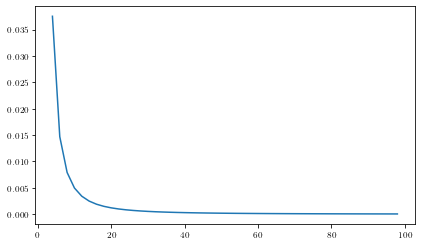

In [213]:
plt.plot(L_list,MI_list)

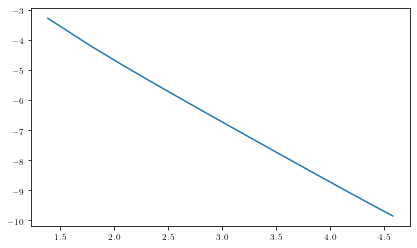

In [214]:
plt.plot(np.log(L_list),np.log(MI_list))

In [215]:
lr=scipy.stats.linregress(np.log(L_list),np.log(MI_list))

In [216]:
lr

LinregressResult(slope=-2.0162210267331844, intercept=-0.646914232931131, rvalue=-0.9998061788310881, pvalue=3.992375114707739e-80, stderr=0.005853801135137841)

In [ ]:
MI_list=[]
L_list=np.arange(4,100,2)
for dist in L_list:    
    params=Params(delta=0.,L=400,bc=-1,basis='m')
    
    MI_list.append(params.mutual_information_m(np.arange(2),np.arange(2)+dist))


# Finite temperature

In [673]:
mutual_info_list={}
mutual_info_pos_list={}
mutual_info_neg_list={}

In [707]:
T0=0.1e-1
# T_list=np.linspace(0,5e-2,100)
# no measurment
delta_list=np.linspace(-1,1,100)**3
mutual_info_list[T0]=[]
for delta in delta_list:    
    params=Params(delta=delta,L=64,bc=-1,T=T0)
    mutual_info_list[T0].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

# all projections to 0
mutual_info_pos_list[T0]=[]
for delta in delta_list:    
    params=Params(delta=delta,L=64,bc=-1,T=T0)
    params.measure_all(1)
    mutual_info_pos_list[T0].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

# all projections to 1
mutual_info_neg_list[T0]=[]
for delta in delta_list:
    params=Params(delta=delta,L=64,bc=-1,T=T0)
    params.measure_all(0)
    mutual_info_neg_list[T0].append(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

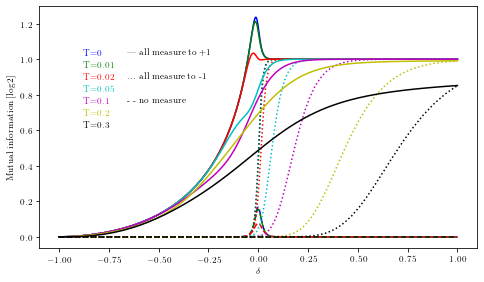

In [734]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
label_height_pos=0.8
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,mutual_info_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,mutual_info_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,mutual_info_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')

fig.tight_layout()
fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T.pdf',bbox_inches='tight')

In [767]:
delta_list=np.linspace(-1,1,100)**3
T_list=np.linspace(0,3e-1,100)

mutual_info_map=np.zeros((len(T_list),len(delta_list)))
mutual_info_pos_map=np.zeros((len(T_list),len(delta_list)))
mutual_info_neg_map=np.zeros((len(T_list),len(delta_list)))

for T_i,T in enumerate(T_list):
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        mutual_info_map[T_i,delta_i]=(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L))

    # all projections to 0
    mutual_info_pos_list[T0]=[]
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(1)
        mutual_info_pos_map[T_i,delta_i]=(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

    # all projections to 1
    mutual_info_neg_list[T0]=[]
    for delta_i,delta in enumerate(delta_list):    
        params=Params(delta=delta,L=64,bc=-1,T=T)
        params.measure_all(0)
        mutual_info_neg_map[T_i,delta_i]=(params.mutual_information_m(np.arange(int(params.L/2)),np.arange(params.L/2)+params.L))

In [ ]:
mutual_info_map

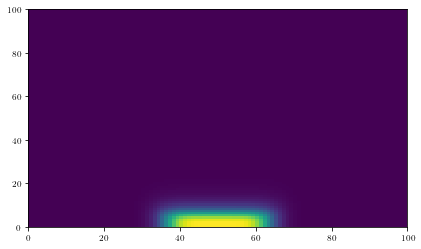

In [770]:
plt.pcolormesh(mutual_info_map)

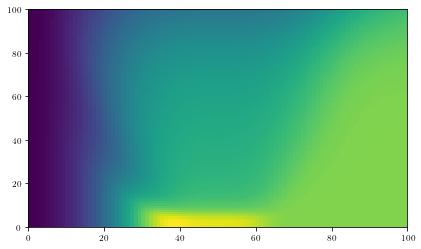

In [769]:
plt.pcolormesh(mutual_info_pos_map)

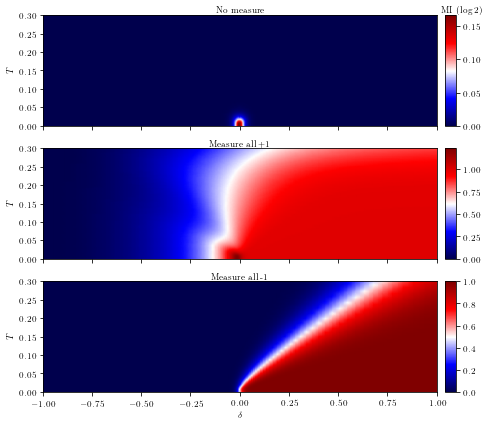

In [814]:
fig,axs=plt.subplots(3,1,sharex=True,sharey=True,figsize=(6.8,6))
color='seismic'
for ax,x in zip(axs,(mutual_info_map,mutual_info_pos_map,mutual_info_neg_map)):
    im=ax.pcolormesh(delta_list,T_list,x/np.log(2),shading='gouraud',cmap=color)
    axins=ax.inset_axes([1.02, 0, 0.03, 1],transform=ax.transAxes)
    cb=fig.colorbar(im,cax=axins)    
    
axs[0].text(1.01,1,'MI (log 2)',transform=axs[0].transAxes,ha='left',va='bottom')
[ax.set_ylabel(r'$T$') for ax in axs]
axs[2].set_xlabel(r'$\delta$')
axs[0].text(.5,1,'No measure',transform=axs[0].transAxes,ha='center',va='bottom')
axs[1].text(.5,1,'Measure all +1',transform=axs[1].transAxes,ha='center',va='bottom')
axs[2].text(.5,1,'Measure all -1',transform=axs[2].transAxes,ha='center',va='bottom')

fig.tight_layout()

fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T_map.pdf',bbox_inches='tight')

## Born rule

In [1205]:
with open('mutual_info_Born_En8.pickle','rb') as f:
    delta_dict_para,mutual_info_dis_dict_para,s_history_dis_dict_para=pickle.load(f)

In [1209]:
delta_dict_para.keys()

dict_keys([0.0, 0.03333333333333333, 0.06666666666666667, 0.1, 0.13333333333333333, 0.16666666666666666, 0.2, 0.23333333333333334, 0.26666666666666666, 0.3])

In [1225]:
np.array(list(s_history_dis_dict_para.values())).shape

(10, 100, 8, 16)

Text(0, 0.5, 'STD of Prob to +1 [$\\log2$]')

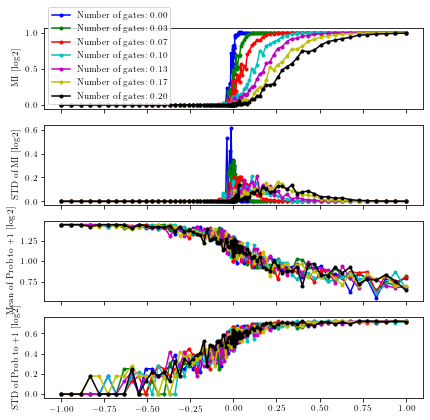

In [1228]:
fig,axs=plt.subplots(4,1,figsize=(6.8,6.8),sharex=True)
colorlist='bgrcmyk'
ax=axs[0]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='Number of gates: {:.2f}'.format(i),color=color)
ax.legend()
ax.set_ylabel(r'MI [$\log2$]')

ax=axs[1]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(mutual_info_dis_dict_para[i],axis=1)/np.log(2),'.-',label='Number of gates: {:.2f}'.format(i),color=color)
ax.set_ylabel(r'STD of MI [$\log2$]')

ax=axs[2]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.mean(s_history_dis_dict_para[i],axis=(1,2))/np.log(2),'.-',label='Number of gates: {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'Mean of Prob to +1 [$\log2$]')

ax=axs[3]
for i,color in zip(delta_dict_para.keys(),colorlist):
    ax.plot(delta_dict_para[i],np.std(s_history_dis_dict_para[i],axis=(1,2))/np.log(2),'.-',label='Number of gates: {:.2f}'.format(i),color=color)
# ax.legend()
ax.set_ylabel(r'STD of Prob to +1 [$\log2$]')

In [ ]:
fig,ax=plt.subplots(figsize=(6.8,4))
colorlist=iter('bgrcmyk')
label_height_pos=0.8
for T0,color in zip((0,0.1e-1,0.2e-1,0.5e-1,1e-1,2e-1,3e-1),colorlist):
    ax.plot(delta_list,mutual_info_list[T0]/np.log(2),'-',label='no measure, T={:.2f}'.format(T0),color=color,ls='--')
    ax.plot(delta_list,mutual_info_pos_list[T0]/np.log(2),'-',label='measure all +1, T={:.2f}'.format(T0),color=color,ls='-')
    ax.plot(delta_list,mutual_info_neg_list[T0]/np.log(2),'-',label='measure all -1, T={:.2f}'.format(T0),color=color,ls=':')
    # ax.text(0.1,label_height_pos+0.01,'*',color=color,transform=ax.transAxes,ha='right')
    ax.text(0.1,label_height_pos,'T={}'.format(T0),color=color,transform=ax.transAxes)
    label_height_pos-=0.05

ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'Mutual information [$\log 2$]')
# ax.legend()
ax.text(0.2,0.8,'--- all measure to +1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.7,'... all measure to -1',transform=ax.transAxes,ha='left')
ax.text(0.2,0.6,'- - no measure',transform=ax.transAxes,ha='left')

fig.tight_layout()
# fig.savefig('/mnt/d/kitp/Rp_SPT/5/MI_Finite_T.pdf',bbox_inches='tight')

# Evolution

In [333]:
params=Params(delta=0.3,L=32,bc=-1)
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)
# params.measure_batch(1,(params.L/2,params.L))
params.measure(1,20,21)
params.measure(0,25,26)
params.measure(1,40,41)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [274]:
params.mutual_information_m(np.arange(int(params.L/2)),np.arange(int(params.L/2))+params.L)

1.8106183219401828e-10

In [295]:
params.i_history

[21]

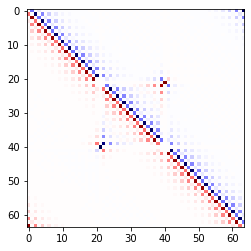

In [305]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(1,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

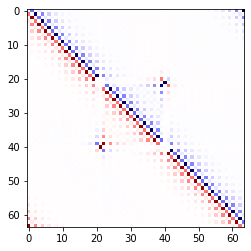

In [304]:
params=Params(delta=0.3,L=32,bc=-1)
params.measure(0,40,21)
i=1
fig,ax=plt.subplots()
ax.imshow(params.C_m_history[i],cmap='seismic',vmin=-1,vmax=1)
# ax.text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',params.i_history[i-1],params.i_history[i-1]+1),transform=ax.transAxes)

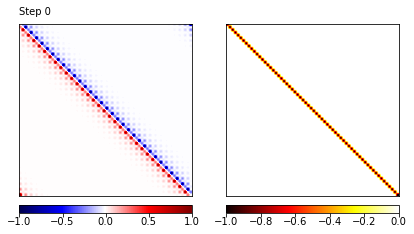

In [290]:
i=0
c_m=params.C_m_history[0]
fig,ax=plt.subplots(1,2,figsize=(6.8,10))

im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].text(0,1.05,'Step 0',transform=ax[0].transAxes)

axins0=ax[0].inset_axes([0.0, -.1, 1, 0.05],transform=ax[0].transAxes) 
cb0=fig.colorbar(im_1,cax=axins0,orientation='horizontal')
cb0.ax.xaxis.set_tick_params(pad=0)
# cb0.ax.tick_params(labelsize=20)

axins1=ax[1].inset_axes([0.0, -.1, 1, 0.05],transform=ax[1].transAxes) 
cb1=fig.colorbar(im_2,cax=axins1,orientation='horizontal')
cb1.ax.xaxis.set_tick_params(pad=0)
# cb1.ax.tick_params(labelsize=20)

# fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [276]:
%%capture
for i,c_m,s,ii in zip(range(1,21),params.C_m_history[1:],params.s_history,params.i_history):
    
    fig,ax=plt.subplots(1,2,figsize=(6.8,10))

    im_1=ax[0].imshow(c_m,cmap='seismic',vmin=-1,vmax=1) 
    im_2=ax[1].imshow(c_m@c_m,cmap='hot',vmin=-1,vmax=0) 

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[0].text(0,1.05,r'Step {}: $\Upsilon_{}({},{})$'.format(i,'{'+str((-1)**s)+'}',ii,ii+1),transform=ax[0].transAxes)

    # fig.savefig('/mnt/d/kitp/Rp_SPT/4/evolution_trivial_{}.pdf'.format(i),bbox_inches='tight',dpi=500)

In [277]:
tex_text="""
    \\begin{{figure}}[h]
        \\centering
        \\includegraphics[width=\\textwidth]{{evolution_trivial_{}.pdf}}
    \\end{{figure}}
    """

In [ ]:
string=""
for i in range(21):
    print(tex_text.format(i))

In [ ]:
print(string)

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m@c_m)

In [ ]:
plt.imshow(params.C_m_history[1])

In [ ]:
params.measure(0, 4, 5)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
params.measure(0, 4, 5)

In [ ]:
params.measure(1, 6, 7)

In [ ]:
params.measure(1, 4, 5)

In [ ]:
params=Params(delta=-0.3,L=16,bc=0)
params.mutual_information_m(np.arange(2),np.arange(2)+16)
params.measure_batch(100)

In [ ]:
params.mutual_information_m(np.arange(2),np.arange(2)+16)

0.0019446062606200964

In [ ]:
len(params.C_m_history)

4

In [ ]:
params.i_history

[13, 14, 3, 14]

In [ ]:
params.s_history

[1, 0, 0, 1]

In [ ]:
for c_m in params.C_m_history:
    fig,ax=plt.subplots()
    ax.imshow(c_m)

# Test

In [95]:
params=Params(delta=-0.3,L=16,bc=0)

/home/jake/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [46]:
params.c_subregion_m(np.arange(4))

array([[ 0.        , -0.96230698,  0.        , -0.24872714],
       [ 0.96230698,  0.        , -0.26943816,  0.        ],
       [ 0.        ,  0.26943816,  0.        , -0.92668984],
       [ 0.24872714,  0.        ,  0.92668984,  0.        ]])

In [47]:
params.c_subregion_m_obs(np.arange(4))-params.c_subregion_m(np.arange(4))

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [48]:
params.c_subregion_m([0,1,2,3]+[8,9,10,11])-params.c_subregion_m_obs([0,1,2,3]+[8,9,10,11])

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [101]:
start_time=time.time()
z=params.c_subregion_m(np.concatenate([np.arange(2),np.arange(2)+10]))
print(time.time()-start_time)

0.0008518695831298828


In [103]:
start_time=time.time()
z_obs=params.c_subregion_m_obs(np.concatenate([np.arange(2),np.arange(2)+10]))
print(time.time()-start_time)

0.001998424530029297


In [104]:
z_obs-z

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [59]:
np.concatenate([np.arange(20),np.arange(20)+10]).shape

(40,)

In [57]:
params.C_m_history

[array([[ 0.00000000e+00, -9.62306978e-01,  0.00000000e+00, ...,
         -2.21666121e-05,  0.00000000e+00, -1.16243430e-05],
        [ 9.62306978e-01,  0.00000000e+00, -2.69438161e-01, ...,
          0.00000000e+00, -3.11525065e-07,  0.00000000e+00],
        [ 0.00000000e+00,  2.69438161e-01,  0.00000000e+00, ...,
         -4.23377965e-05,  0.00000000e+00, -2.21666121e-05],
        ...,
        [ 2.21666121e-05,  0.00000000e+00,  4.23377965e-05, ...,
          0.00000000e+00, -2.69438161e-01,  0.00000000e+00],
        [ 0.00000000e+00,  3.11525065e-07,  0.00000000e+00, ...,
          2.69438161e-01,  0.00000000e+00, -9.62306978e-01],
        [ 1.16243430e-05,  0.00000000e+00,  2.21666121e-05, ...,
          0.00000000e+00,  9.62306978e-01,  0.00000000e+00]])]